In [1]:
# ================================================================
# 01_preprocess.py  –  Pré-processamento diário (versão peso em gramas)
# ------------------------------------------------------------
# Este script lê o arquivo Excel `datasets/dados.xlsx`, aplica
# validações robustas, trata outliers e gera os 15 indicadores
# diários exigidos pelo projeto. Agora o peso é convertido de kg
# para gramas (`peso_g`). As razões por kg continuam corretas ao
# dividir `peso_g` por 1 000.
# ------------------------------------------------------------
# Como usar (terminal macOS, já com venv ativo):
#   python src/01_preprocess.py
# ------------------------------------------------------------
# Requisitos: pandas, numpy, pyarrow, openpyxl, tqdm (opcional)
# Instalação sugerida (brew + pip):
#   brew install pyarrow
#   pip install pandas numpy openpyxl tqdm
# ================================================================

!pip install tensorflow tensorflow-probability pandas numpy matplotlib networkx openpyxl pyarrow tqdm keras

from __future__ import annotations

import sys
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Configurações básicas
# -----------------------------------------------------------------

DATA_PATH = Path("dados.xlsx")  # input
OUTPUT_PATH = Path("dados_diarios_preproc.parquet")  # output

# Colunas mínimas que o pipeline não pode rodar sem
REQUIRED_COLS = {
    "data", "peso_kg",
    "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade",
    "passos", "minutos_em_pe",
    "fc_repouso_bpm", "hrv_medio",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Colunas que não podem ter valores negativos
NON_NEGATIVE = {
    "peso_kg", "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade", "passos", "minutos_em_pe",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Quantis usados para winsorização
QUANT_LOW, QUANT_HIGH = 0.05, 0.95

# -----------------------------------------------------------------
# 2. Funções utilitárias
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê o Excel, normaliza nomes de colunas e remove duplicatas.

    - `strip()` espaços iniciais/finais
    - converte a `snake_case` mínima (lower)
    - se nomes repetirem, mantém somente a primeira ocorrência
    """
    df = pd.read_excel(path, engine="openpyxl")

    # normaliza cabeçalhos
    new_cols = []
    seen = set()
    for raw in df.columns:
        col = str(raw).strip()
        col = col.replace(" ", "_").lower()
        if col in seen:
            warnings.warn(
                f"Coluna duplicada encontrada e ignorada: '{col}'. Somente a primeira ocorrência será usada.",
                RuntimeWarning,
            )
            continue
        new_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = new_cols
    return df


def winsorize(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Aplica winsorização p5–p95 inplace para as colunas fornecidas."""
    for col in tqdm(cols, desc="Winsorizando", leave=False):
        lo, hi = df[col].quantile([QUANT_LOW, QUANT_HIGH], interpolation="linear")
        df[col] = df[col].clip(lo, hi)
    return df

# -----------------------------------------------------------------
# 3. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not DATA_PATH.exists():
        sys.exit(f"❌ Arquivo de dados não encontrado em {DATA_PATH.resolve()}")

    print("📥  Lendo planilha…")
    df = read_excel_unique(DATA_PATH)

    # ----- validação de colunas essenciais -----
    missing = sorted(REQUIRED_COLS - set(df.columns))
    if missing:
        sys.exit(f"❌ Faltando colunas obrigatórias: {missing}")

    # ----- normalização de tipos & valores impossíveis -----
    print("🧹  Ajustando tipos e valores…")
    df["data"] = pd.to_datetime(df["data"], errors="coerce")

    for col in NON_NEGATIVE & set(df.columns):
        df.loc[df[col] < 0, col] = np.nan

    # ----- converte peso para gramas e remove peso_kg -----
    df["peso_g"] = df["peso_kg"] * 1000.0  # precisão em gramas
    df.drop(columns="peso_kg", inplace=True)

    # ----- winsorização p5–p95 -----
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    winsorize(df, numeric_cols)

    # -----------------------------------------------------------------
    # 4. Cálculo dos indicadores
    # -----------------------------------------------------------------
    print("🧮  Calculando indicadores…")

    df_ind = pd.DataFrame()
    df_ind["data"] = df["data"]

    # cópias diretas
    df_ind["Fat_pct_mean"]          = df["gordura_pct"]
    df_ind["Circumference_cm_med"] = df["circunferencia_cm"]
    df_ind["Total_kcal_mean"]       = df["energia_total"]
    df_ind["Steps_mean"]            = df["passos"]
    df_ind["RestingHR_mean"]        = df["fc_repouso_bpm"]
    df_ind["HRV_mean"]              = df["hrv_medio"]
    df_ind["SleepDur_mean"]         = df["duracao_sono_min"]
    df_ind["Water_ml_mean"]         = df["agua_consumida_ml"]

    # derivadas / razões
    df_ind["Lean_to_Fat_ratio"]       = df["massa_magra_pct"] / df["gordura_pct"]
    df_ind["Activity_kcal_fraction"]  = df["energia_atividade"] / df["energia_total"]
    df_ind["Standing_minutes_raw"]    = df["minutos_em_pe"]  # para desvio-padrão futuro
    df_ind["DeepFrac_mean"]           = df["minutos_deep"] / df["duracao_sono_min"]

    # razões por kg – dividimos peso em gramas por 1000
    kg_denominator = df["peso_g"] / 1000.0
    df_ind["Carb_per_kg_mean"]        = df["carboidratos_g"] / kg_denominator
    df_ind["Protein_per_kg_mean"]     = df["proteinas_g"] / kg_denominator

    # déficit calórico permanece igual
    df_ind["Cal_deficit_mean"]        = df["calorias_consumidas"] - df["energia_total"]

    # ----- salva parquet -----
    print("💾  Gravando Parquet…")
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_ind.sort_values("data").to_parquet(OUTPUT_PATH, index=False, engine="pyarrow")

    # resumo rápido
    print("\n✅  Pré-processamento concluído!")
    print(f"Arquivo salvo em: {OUTPUT_PATH.resolve()}")
    print("\nResumo numérico (pós-winsor):")
    print(df_ind.describe().loc[["mean", "std", "min", "max"]].round(2))


if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 598.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


📥  Lendo planilha…
🧹  Ajustando tipos e valores…


🧮  Calculando indicadores…
💾  Gravando Parquet…

✅  Pré-processamento concluído!
Arquivo salvo em: /content/dados_diarios_preproc.parquet

Resumo numérico (pós-winsor):
                     data  Fat_pct_mean  Circumference_cm_med  \
mean  2026-05-15 12:00:00         20.04                 79.93   
std                   NaN          1.78                  4.43   
min   2025-01-01 00:00:00         16.90                 72.09   
max   2027-09-27 00:00:00         23.30                 88.10   

      Total_kcal_mean  Steps_mean  RestingHR_mean  HRV_mean  SleepDur_mean  \
mean          2002.13     7453.53           62.05     50.13         481.06   
std            112.16     2510.73            4.34      8.70          23.26   
min           1800.95     3514.00           55.00     35.20         441.00   
max           2213.10    11471.70           69.00     66.20         523.00   

      Water_ml_mean  Lean_to_Fat_ratio  Activity_kcal_fraction  \
mean        2241.66               3.78          

WIndows cons

In [2]:
# ================================================================
# 02_window_construction.py – Construção das janelas de 91 dias
# ------------------------------------------------------------
# Pipeline comentado linha a linha:
#   1. Lê o parquet diário com 15 indicadores + peso em gramas.
#   2. Anexa o peso (g) para cada dia a partir do Excel.
#   3. Desliza janelas de 91 dias (step = 7).
#   4. Agrega indicadores (média, mediana, desvio‑padrão).
#   5. Calcula o alvo: inclinação da reta peso × tempo (kg/sem).
#   6. Salva o resultado em Parquet para uso no BSTS.
# ------------------------------------------------------------
# Execução (terminal macOS):
#   python src/02_window_construction.py
# ------------------------------------------------------------
# Dependências: pandas, numpy, pyarrow, openpyxl, tqdm
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Caminhos e parâmetros
# -----------------------------------------------------------------

DAILY_PARQUET = Path("dados_diarios_preproc.parquet")
EXCEL_SOURCE = Path("dados.xlsx")
WINDOW_PARQUET = Path("janelas_91d.parquet")

WINDOW_SIZE = 91   # dias na janela
STEP_SIZE = 7      # deslocamento

# -----------------------------------------------------------------
# 2. Leitura defensiva do Excel (sem colunas duplicadas)
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê Excel, normaliza cabeçalhos e descarta colunas duplicadas."""
    df = pd.read_excel(path, engine="openpyxl")

    norm_cols, seen = [], set()
    for raw in df.columns:
        col = str(raw).strip().replace(" ", "_").lower()
        if col in seen:
            warnings.warn(f"Coluna duplicada ignorada: {col}")
            continue
        norm_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = norm_cols
    return df

# -----------------------------------------------------------------
# 3. Funções de agregação por janela
# -----------------------------------------------------------------

def slope_kg_per_week(sub: pd.DataFrame) -> float:
    """Inclinação da reta de peso (kg/semana) dentro de uma janela."""
    y = sub["peso_g"].values / 1000.0  # g → kg
    if np.isnan(y).any():
        return np.nan
    x = np.arange(len(sub))            # 0..90
    slope_day = np.polyfit(x, y, 1)[0] # kg/dia
    return slope_day * 7               # kg/semana


def aggregate_window(sub: pd.DataFrame) -> dict:
    """Calcula métricas da janela (mean, median, std) + alvo."""
    out: dict[str, float] = {}

    # --- médias (11) ---
    mean_cols = {
        "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
        "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
        "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    }
    for c in mean_cols:
        out[c] = sub[c].mean()

    # --- mediana (1) ---
    out["Circumference_cm_med"] = sub["Circumference_cm_med"].median()

    # --- desvio‑padrão (1) ---
    out["Standing_variability"] = sub["Standing_minutes_raw"].std()

    # --- razões por kg (2) ---
    out["Carb_per_kg_mean"]    = sub["Carb_per_kg_mean"].mean()
    out["Protein_per_kg_mean"] = sub["Protein_per_kg_mean"].mean()

    # --- alvo ---
    out["slope_kg_per_week"] = slope_kg_per_week(sub)
    return out


def generate_windows(df: pd.DataFrame) -> pd.DataFrame:
    """Gera DataFrame final: 1 linha por janela deslizante."""
    records = []
    starts = range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE)
    for i in tqdm(starts, desc="Gerando janelas"):
        sub = df.iloc[i : i + WINDOW_SIZE]
        rec = aggregate_window(sub)
        rec["window_start"] = sub["data"].iloc[0]
        records.append(rec)
    return pd.DataFrame(records)

# -----------------------------------------------------------------
# 4. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    # 4.1 Carrega indicadores diários
    if not DAILY_PARQUET.exists():
        sys.exit("❌ Parquet diário não encontrado. Rode 01_preprocess.py primeiro.")
    df_ind = pd.read_parquet(DAILY_PARQUET)

    # 4.2 Anexa peso (g)
    df_weight = read_excel_unique(EXCEL_SOURCE)[["data", "peso_kg"]]
    df_weight["data"] = pd.to_datetime(df_weight["data"], errors="coerce")
    df_weight["peso_g"] = df_weight["peso_kg"] * 1000.0

    # merge (inner) – remove datas sem indicador ou sem peso
    df_full = (
        df_ind.merge(df_weight[["data", "peso_g"]], on="data", how="inner")
               .sort_values("data")
               .reset_index(drop=True)
    )

    # 4.3 Gera janelas
    df_windows = generate_windows(df_full)

    # 4.4 Salva
    WINDOW_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    df_windows.to_parquet(WINDOW_PARQUET, index=False, engine="pyarrow")

    # 4.5 Resumo
    print("✅  Janelas salvas em:", WINDOW_PARQUET.resolve())
    print("Total de janelas:", len(df_windows))
    print(df_windows.head())


if __name__ == "__main__":
    main()

Gerando janelas: 100%|██████████| 130/130 [00:00<00:00, 899.81it/s]

✅  Janelas salvas em: /content/janelas_91d.parquet
Total de janelas: 130
   RestingHR_mean   Steps_mean   HRV_mean  SleepDur_mean  Lean_to_Fat_ratio  \
0       62.428571  7723.165934  50.674725     480.945055           3.764655   
1       62.329670  7671.605495  50.689011     481.340659           3.761750   
2       62.153846  7712.385714  50.395604     481.274725           3.795185   
3       62.373626  7870.154945  50.383516     482.087912           3.809480   
4       62.230769  7917.352747  50.085659     482.824176           3.826643   

   Cal_deficit_mean  Total_kcal_mean  DeepFrac_mean  Fat_pct_mean  \
0       -798.222527      1995.100549       0.300193     20.102198   
1       -803.310989      1991.165934       0.300173     20.115385   
2       -818.147802      1996.847253       0.300144     19.980220   
3       -814.224725      1997.486264       0.300093     19.924176   
4       -802.893407      1991.507143       0.300091     19.842857   

   Water_ml_mean  Activity_kcal_fract

Correlação

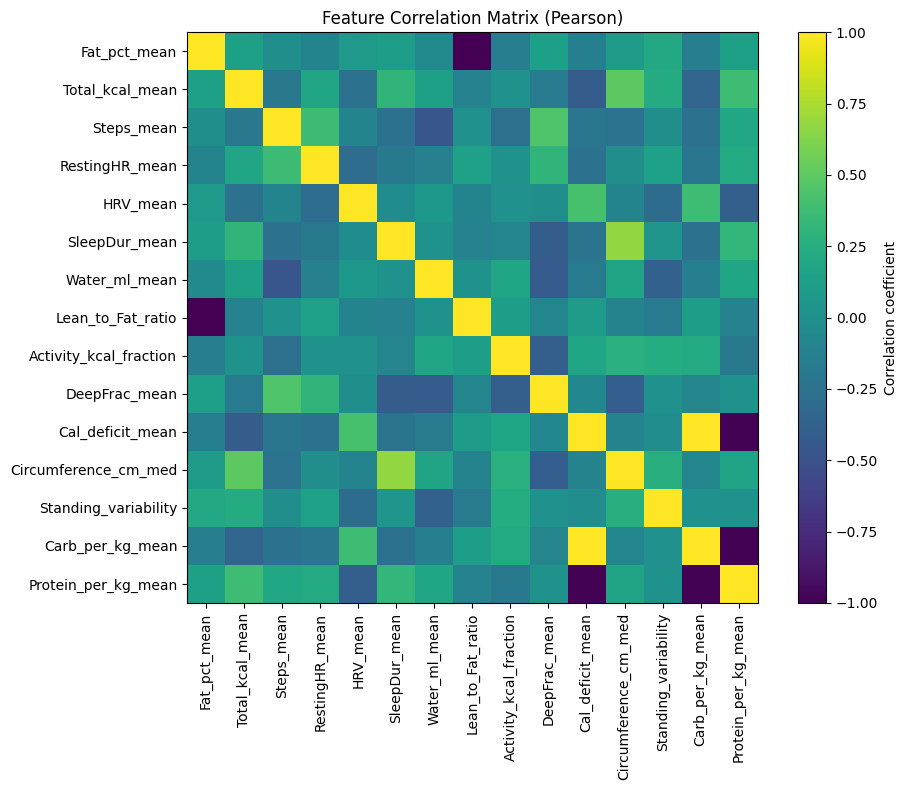

,var1,var2,corr
0,Fat_pct_mean,Lean_to_Fat_ratio,-0.994326
1,Cal_deficit_mean,Carb_per_kg_mean,0.994319
2,Carb_per_kg_mean,Protein_per_kg_mean,-0.988365
3,Cal_deficit_mean,Protein_per_kg_mean,-0.985024


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display

# --- 1. Load the windows data ---
df_windows = pd.read_parquet("janelas_91d.parquet")

# --- 2. Select feature columns ---
feature_cols = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean"
]
X = df_windows[feature_cols]

# --- 3. Correlation matrix ---
corr_matrix = X.corr()

# --- 4. Heatmap (agora com viridis) ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, cmap="viridis")  # ← aqui
ax.set_xticks(range(len(feature_cols)))
ax.set_yticks(range(len(feature_cols)))
ax.set_xticklabels(feature_cols, rotation=90)
ax.set_yticklabels(feature_cols)
ax.set_title("Feature Correlation Matrix (Pearson)")
plt.colorbar(im, ax=ax, label="Correlation coefficient")
plt.tight_layout()
plt.show()

# --- 5. Pairs with |corr| ≥ 0.80 ---
threshold = 0.80
rows = [
    {"var1": feature_cols[i], "var2": feature_cols[j], "corr": corr_matrix.iat[i, j]}
    for i, j in combinations(range(len(feature_cols)), 2)
    if abs(corr_matrix.iat[i, j]) >= threshold
]
high_corr_df = (pd.DataFrame(rows)
                .sort_values("corr", key=np.abs, ascending=False)
                .reset_index(drop=True))

display(high_corr_df)

Tratamento da colinearidade

In [4]:
# ================================================================
# 03_collinearity_filter_v3.py – Colinearidade + estatísticas do slope
# --------------------------------------------------------------------
# • Agrupa variáveis com |ρ| ≥ 0.80 (Pearson) e resolve colinearidade
#   (menor média |ρ| interna, desempate pelo maior |corr(X, y)|).
# • Exibe no relatório, para **cada** variável (mantida ou eliminada):
#     – média |ρ| interna no grupo
#     – |corr(X, slope_kg_per_week)|  (força preditiva univariada)
# • Salva Parquet filtrado + .txt das eliminadas (com estatísticas).
# --------------------------------------------------------------------
# Execução:  python src/03_collinearity_filter_v3.py
# Dependências: pandas, numpy, pyarrow, networkx
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx

# -----------------------------------------------------------------
# Caminhos e parâmetros
# -----------------------------------------------------------------
WINDOW_PARQUET = Path("janelas_91d.parquet")
FILTERED_PARQUET = Path("janelas_91d_filtered.parquet")
REMOVED_TXT = Path("janelas_91d_removed_cols.txt")

THRESHOLD = 0.80  # |ρ| limiar

FEATURE_COLS = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean",
]

TARGET_COL = "slope_kg_per_week"
DATE_COL = "window_start"

# -----------------------------------------------------------------
# Utilitários
# -----------------------------------------------------------------

def build_graph(corr: pd.DataFrame, cols: list[str], thr: float) -> nx.Graph:
    g = nx.Graph()
    g.add_nodes_from(cols)
    for i, c1 in enumerate(cols):
        for c2 in cols[i + 1 :]:
            if abs(corr.loc[c1, c2]) >= thr:
                g.add_edge(c1, c2)
    return g


def pick_keep_column(group: list[str], corr: pd.DataFrame, y_corr: pd.Series) -> str:
    """Menor média |ρ| interna; desempate por maior |corr(X, y)|."""
    mean_r = {
        col: np.mean([abs(corr.loc[col, other]) for other in group if other != col])
        for col in group
    }
    min_mean = min(mean_r.values())
    candidates = [c for c, m in mean_r.items() if np.isclose(m, min_mean)]
    if len(candidates) == 1:
        return candidates[0]
    return max(candidates, key=lambda c: abs(y_corr[c]))

# -----------------------------------------------------------------
# Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not WINDOW_PARQUET.exists():
        sys.exit("❌ Arquivo de janelas não encontrado.")

    df = pd.read_parquet(WINDOW_PARQUET)
    X = df[FEATURE_COLS]
    y = df[TARGET_COL]

    corr = X.corr()
    y_corr = X.apply(lambda col: col.corr(y))  # Series de correlação com y

    graph = build_graph(corr, FEATURE_COLS, THRESHOLD)
    groups = list(nx.connected_components(graph))

    kept, removed_info = [], []
    for grp in groups:
        grp_list = sorted(grp, key=lambda c: FEATURE_COLS.index(c))
        if len(grp_list) == 1:
            kept.append(grp_list[0])
            continue
        keep_col = pick_keep_column(grp_list, corr, y_corr)
        kept.append(keep_col)
        for col in grp_list:
            if col == keep_col:
                continue
            mean_internal = np.mean([abs(corr.loc[col, other]) for other in grp_list if other != col])
            removed_info.append((col, mean_internal, abs(y_corr[col])))

    # Ordena pelo índice original
    kept.sort(key=lambda c: FEATURE_COLS.index(c))
    removed_info.sort(key=lambda t: FEATURE_COLS.index(t[0]))

    # --- Relatório ---
    print("Mantidas (", len(kept), ") – estatísticas:")
    for col in kept:
        # média |ρ| dentro do grupo se houver conexão; caso contrário, NaN → "—"
        internal_vals = [abs(corr.loc[col, other]) for other in FEATURE_COLS if other != col and abs(corr.loc[col, other]) >= THRESHOLD]
        mean_int = np.mean(internal_vals) if internal_vals else np.nan
        mean_text = f"{mean_int:.3f}" if not np.isnan(mean_int) else "—"
        print(f"  {col:<25} média|ρ_grupo|={mean_text:<5}  |ρ(col,y)|={abs(y_corr[col]):.3f}")

    print("\nEliminadas (", len(removed_info), ") – média|ρ| e |ρ(col,y)|:")
    for col, m_int, rho_y in removed_info:
        print(f"  {col:<25} {m_int:.3f} {rho_y:.3f}")

    # Salva arquivos
    df[kept + [TARGET_COL, DATE_COL]].to_parquet(FILTERED_PARQUET, index=False, engine="pyarrow")
    with REMOVED_TXT.open("w") as f:
        for col, m_int, rho_y in removed_info:
            f.write(f"{col}\t{m_int:.3f}\t{rho_y:.3f}\n")

    print("\n✅ Parquet filtrado salvo em:", FILTERED_PARQUET.resolve())
    print("Lista detalhada em:", REMOVED_TXT.resolve())


if __name__ == "__main__":
    main()

Mantidas ( 12 ) – estatísticas:
  Fat_pct_mean              média|ρ_grupo|=0.994  |ρ(col,y)|=0.169
  Total_kcal_mean           média|ρ_grupo|=—      |ρ(col,y)|=0.347
  Steps_mean                média|ρ_grupo|=—      |ρ(col,y)|=0.336
  RestingHR_mean            média|ρ_grupo|=—      |ρ(col,y)|=0.127
  HRV_mean                  média|ρ_grupo|=—      |ρ(col,y)|=0.024
  SleepDur_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.099
  Water_ml_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.451
  Activity_kcal_fraction    média|ρ_grupo|=—      |ρ(col,y)|=0.077
  DeepFrac_mean             média|ρ_grupo|=—      |ρ(col,y)|=0.304
  Circumference_cm_med      média|ρ_grupo|=—      |ρ(col,y)|=0.156
  Standing_variability      média|ρ_grupo|=—      |ρ(col,y)|=0.026
  Protein_per_kg_mean       média|ρ_grupo|=0.987  |ρ(col,y)|=0.068

Eliminadas ( 3 ) – média|ρ| e |ρ(col,y)|:
  Lean_to_Fat_ratio         0.994 0.160
  Cal_deficit_mean          0.990 0.085
  Carb_per_kg_mean          0.991 0.055



Antes e depois (colinearidade)


/tmp/ipython-input-5-1640644050.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1])


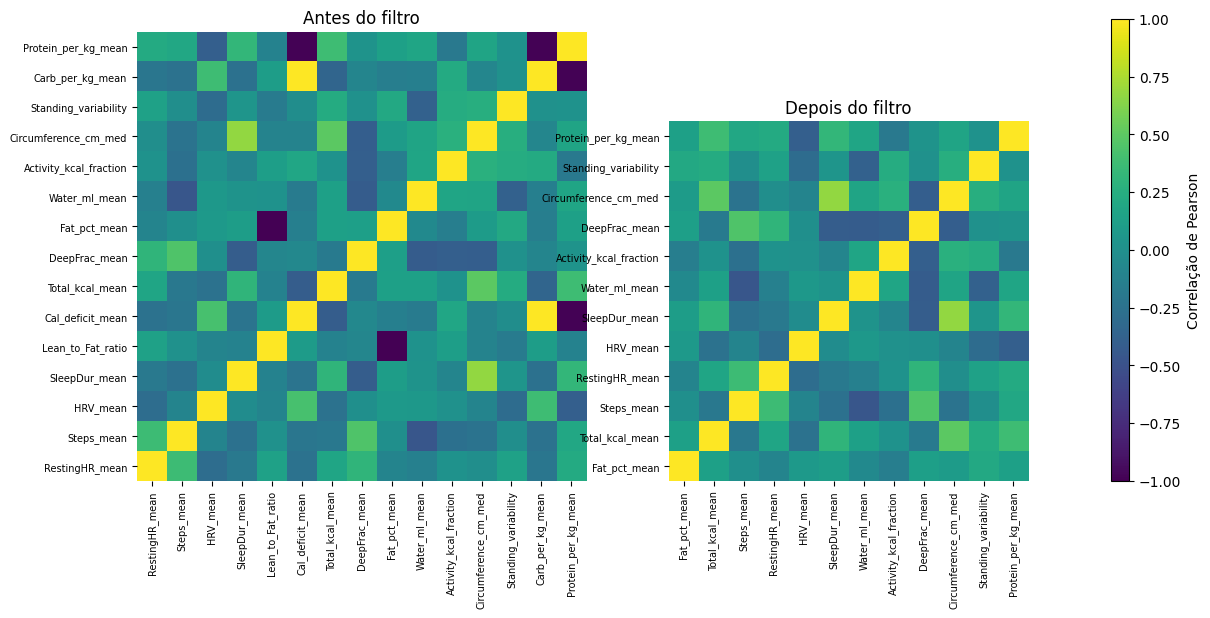

In [5]:
# ================================================================
# Célula: Heat-map de correlações ANTES × DEPOIS (versão 8)
# ----------------------------------------------------------------
# • Quadrículas de tamanho idêntico (aspect="equal") em ambos painéis.
# • Bases alinhadas pelo canto inferior-esquerdo (anchor SW).
# • Painel “Depois” pode ser visualmente menor; espaço vazio aparece
#   acima dele (fundo branco), não há distorção.
# • Colorbar fixa à direita, spines removidos.
# ================================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

BEFORE_PATH = "janelas_91d.parquet"
AFTER_PATH  = "janelas_91d_filtered.parquet"
TARGET = "slope_kg_per_week"
DATE   = "window_start"

# ---- Load data ----
df_before = pd.read_parquet(BEFORE_PATH)
df_after  = pd.read_parquet(AFTER_PATH)

feat_before = [c for c in df_before.columns if c not in {TARGET, DATE}]
feat_after  = [c for c in df_after.columns  if c not in {TARGET, DATE}]

corr_before = df_before[feat_before].corr()
corr_after  = df_after[feat_after].corr()

n_before = len(feat_before)
n_after  = len(feat_after)

# ---- Figure layout ----
cell = 0.4  # polegadas por célula (tamanho base)
fig_width = cell * (n_before + n_after) + 2  # +2 for colorbar & margins
fig_height = cell * n_before
fig = plt.figure(figsize=(fig_width, fig_height))

# GridSpec: width proportional to #cols, single row
gs = GridSpec(1, 3, width_ratios=[n_before, n_after, 0.6], wspace=0.3)
ax_before = fig.add_subplot(gs[0])
ax_after  = fig.add_subplot(gs[1])
cb_ax     = fig.add_subplot(gs[2])

cmap = mpl.colormaps["viridis"].copy()

# ---- Helper: clean spines/anchor and set aspect ----
for ax in (ax_before, ax_after):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_anchor("SW")
    ax.set_aspect("equal", adjustable="box")

ax_after.set_facecolor("white")

# ---- Plot BEFORE ----
ax_before.imshow(corr_before.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_before.set_xticks(range(n_before))
ax_before.set_yticks(range(n_before))
ax_before.set_xticklabels(feat_before, rotation=90, fontsize=7)
ax_before.set_yticklabels(feat_before, fontsize=7)
ax_before.set_title("Antes do filtro")

# ---- Plot AFTER ----
ax_after.imshow(corr_after.values, vmin=-1, vmax=1, cmap=cmap, origin="lower")
ax_after.set_xticks(range(n_after))
ax_after.set_yticks(range(n_after))
ax_after.set_xticklabels(feat_after, rotation=90, fontsize=7)
ax_after.set_yticklabels(feat_after, fontsize=7)
ax_after.set_title("Depois do filtro")

# Align bases – ensured by anchor SW and equal aspect; no extra code

# ---- Colorbar ----
fig.colorbar(ax_before.images[0], cax=cb_ax, label="Correlação de Pearson")
cb_ax.yaxis.set_ticks_position("right")

# ---- Layout ----
fig.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

grafo de colinearidade (network graph)

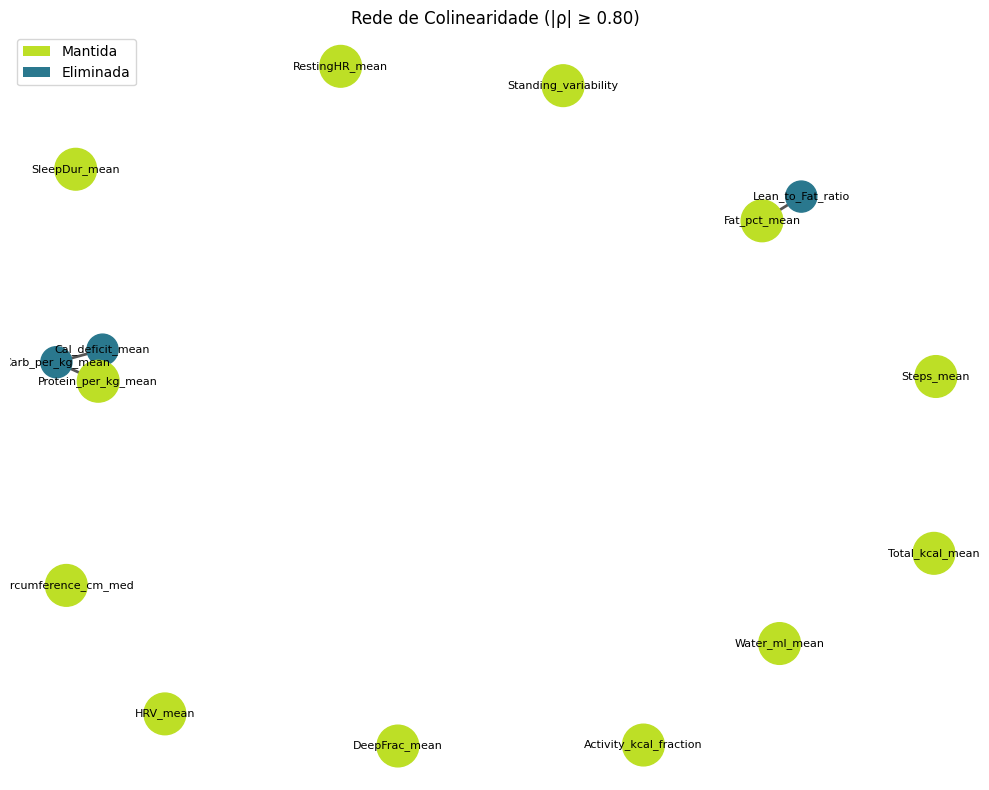

In [6]:
# ================================================================
# Célula: Rede de Colinearidade (versão 2 — viridis + legenda)
# ----------------------------------------------------------------
# • Grafo com variáveis como nós; arestas se |ρ| ≥ 0.80.
# • Paleta **viridis** para consistência visual: nós mantidos = tom
#   escuro, eliminados = tom claro.
# • Legenda adicionada explicando as duas cores.
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from matplotlib.patches import Patch

PARQUET_BEFORE = "janelas_91d.parquet"
PARQUET_AFTER  = "janelas_91d_filtered.parquet"
TARGET = "slope_kg_per_week"
DATE   = "window_start"
THRESHOLD = 0.80

# ---- Load datasets ----
df_before = pd.read_parquet(PARQUET_BEFORE)
df_after  = pd.read_parquet(PARQUET_AFTER)

features_all  = [c for c in df_before.columns if c not in {TARGET, DATE}]
features_keep = [c for c in df_after.columns  if c not in {TARGET, DATE}]

corr = df_before[features_all].corr()

# ---- Build graph ----
G = nx.Graph()
G.add_nodes_from(features_all)
for i, c1 in enumerate(features_all):
    for c2 in features_all[i + 1 :]:
        if abs(corr.loc[c1, c2]) >= THRESHOLD:
            G.add_edge(c1, c2, weight=abs(corr.loc[c1, c2]))

# ---- Node styling (viridis) ----
cmap = mpl.colormaps["viridis"]
color_keep = cmap(0.9)   # mais escuro
color_drop = cmap(0.4)   # mais claro
node_colors = [color_keep if n in features_keep else color_drop for n in G.nodes]
node_sizes  = [900 if n in features_keep else 500 for n in G.nodes]

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))

# Edges com alpha proporcional ao peso
edge_weights = [G[u][v]['weight'] for u, v in G.edges]
max_w = max(edge_weights) if edge_weights else 1
for (u, v), w in zip(G.edges, edge_weights):
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=2,
        alpha=w / max_w, edge_color="#555555"
    )

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_labels(G, pos, font_size=8)

# ---- Legend ----
legend_elements = [
    Patch(facecolor=color_keep, edgecolor='none', label='Mantida'),
    Patch(facecolor=color_drop, edgecolor='none', label='Eliminada'),
]
plt.legend(handles=legend_elements, loc="upper left")

plt.title("Rede de Colinearidade (|ρ| ≥ 0.80)")
plt.axis("off")
plt.tight_layout()
plt.show()

Prepare model data

In [7]:
# ================================================================
# 04_prepare_model_data.py – Normalização, split e estatísticas
# ------------------------------------------------------------
# • Carrega janelas filtradas (sem colinearidade).
# • Normaliza via z-score usando médias/desvios do bloco de treino.
# • Divide cronologicamente em treino inicial (70 %) e walk-forward.
# • Salva Parquets + json de scalers.
# • Imprime tabela .describe() das features normalizadas (treino)
#   e resumo do alvo slope_kg_per_week (treino vs. walk).
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd

FILTERED_PARQUET = Path("janelas_91d_filtered.parquet")
TRAIN_PARQUET    = Path("train_initial.parquet")
WALK_PARQUET     = Path("walk_forward.parquet")
SCALER_JSON      = Path("feature_scalers.json")

TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"
TRAIN_FRAC = 0.70  # 70 % janelas mais antigas → treino inicial

# -----------------------------------------------------------------
# Pipeline
# -----------------------------------------------------------------

def main() -> None:
    if not FILTERED_PARQUET.exists():
        sys.exit("❌ Parquet filtrado não encontrado. Rode o filtro de colinearidade.")

    df = pd.read_parquet(FILTERED_PARQUET).sort_values(DATE_COL).reset_index(drop=True)
    feature_cols = [c for c in df.columns if c not in {TARGET_COL, DATE_COL}]

    # ---- Split temporal ----
    split_idx = int(len(df) * TRAIN_FRAC)
    df_train = df.iloc[:split_idx].copy()
    df_walk  = df.iloc[split_idx:].copy()

    # ---- Compute scalers on train ----
    means = df_train[feature_cols].mean()
    stds  = df_train[feature_cols].std(ddof=0)

    # save scalers
    SCALER_JSON.write_text(json.dumps({"mean": means.to_dict(), "std": stds.to_dict()}, indent=2))

    # ---- Apply z-score ----
    for col in feature_cols:
        df_train[col] = (df_train[col] - means[col]) / stds[col]
        df_walk[col]  = (df_walk[col]  - means[col]) / stds[col]

    # ---- Save Parquets ----
    TRAIN_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    df_train.to_parquet(TRAIN_PARQUET, index=False, engine="pyarrow")
    df_walk.to_parquet(WALK_PARQUET,  index=False, engine="pyarrow")

    # ---- Report ----
    print("✅ Dados preparados:")
    print(f"  Treino inicial : {len(df_train)} janelas → {TRAIN_PARQUET}")
    print(f"  Walk-forward   : {len(df_walk)} janelas → {WALK_PARQUET}")
    print("  Escalers salvos em:", SCALER_JSON)

    # ---- Extra stats ----
    print("\n### Estatísticas das features normalizadas (treino)\n")
    print(df_train[feature_cols].describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

    print("\n### Resumo do alvo slope_kg_per_week\n")
    for name, dset in {"Treino": df_train, "Walk": df_walk}.items():
        s = dset[TARGET_COL]
        print(f"{name:<7} → média: {s.mean():.3f}  desvio: {s.std():.3f}  min: {s.min():.3f}  max: {s.max():.3f}")


if __name__ == "__main__":
    main()

✅ Dados preparados:
  Treino inicial : 91 janelas → train_initial.parquet
  Walk-forward   : 39 janelas → walk_forward.parquet
  Escalers salvos em: feature_scalers.json

### Estatísticas das features normalizadas (treino)

                        mean    std    min    25%    50%    75%    max
Fat_pct_mean             0.0  1.006 -2.331 -0.781  0.058  0.801  2.273
Total_kcal_mean         -0.0  1.006 -1.826 -0.927  0.063  0.913  1.971
Steps_mean              -0.0  1.006 -2.013 -0.844  0.021  0.837  1.963
RestingHR_mean           0.0  1.006 -2.515 -0.726  0.063  0.697  2.063
HRV_mean                -0.0  1.006 -2.038 -0.763 -0.205  0.823  2.122
SleepDur_mean           -0.0  1.006 -1.770 -0.923 -0.049  0.847  2.247
Water_ml_mean           -0.0  1.006 -1.670 -0.735 -0.151  0.650  2.775
Activity_kcal_fraction   0.0  1.006 -1.623 -0.702 -0.111  0.609  2.606
DeepFrac_mean            0.0  1.006 -2.125 -0.550 -0.145  0.537  2.750
Circumference_cm_med     0.0  1.006 -1.839 -0.822 -0.386  1.066  2

# Model

Bsts Step1 Define Model

In [9]:
# ================================================================
# 05_define_bsts_model.py – Passo 1: Estrutura do BSTS em TFP
# ----------------------------------------------------------------
# • Carrega train_initial.parquet (features normalizadas + target).
# • Define componentes (tendência local + regressão exógena).
# • Agrupa índices de features para priors hierárquicos.
# • **Adição**: barra de progresso (tqdm) enquanto mapeia os grupos.
# ================================================================

!pip install tf_keras

import os
# — remova ou comente estas três linhas para habilitar GPU —
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # força CPU

import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from pathlib import Path
from tqdm import tqdm  # barra de progresso

# --- Config paths ---
TRAIN_PARQUET = Path("train_initial.parquet")
TARGET_COL = "slope_kg_per_week"
DATE_COL   = "window_start"

# --- Load data ---
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]

# Convert to tensors
observed_time_series = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
exog_regressors = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# --- Component 1: Local Linear Trend ---
trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)

# --- Component 2: Exogenous Regression ---
regression = tfp.sts.LinearRegression(design_matrix=exog_regressors, name="ExogenousRegs")

# --- Build model ---
model = tfp.sts.Sum(components=[trend, regression], observed_time_series=observed_time_series)

print("Modelo BSTS definido com:")
print(" • Tendência local")
print(f" • Regressão exógena com {len(feature_cols)} features")
print("Componentes prontos para receber priors hierárquicos no Passo 2.")

# --- Save feature groups for priors ---
feature_groups = {
    "comp_corporal": ["Fat_pct_mean", "Lean_to_Fat_ratio", "Circumference_cm_med"],
    "gasto_energetico": ["Total_kcal_mean", "Activity_kcal_fraction"],
    "atividade": ["Steps_mean", "Standing_variability"],
    "cardio": ["RestingHR_mean", "HRV_mean"],
    "sono": ["SleepDur_mean", "DeepFrac_mean"],
    "nutrientes": ["Carb_per_kg_mean", "Protein_per_kg_mean"],
    "ingestao_hidratacao": ["Cal_deficit_mean", "Water_ml_mean"],
}

print("Mapeando índices de features por grupo…")
# Barra de progresso por grupo
group_indices = {}
for g, cols in tqdm(list(feature_groups.items()), desc="Grupos"):
    group_indices[g] = [feature_cols.index(col) for col in cols if col in feature_cols]

GROUPS_JSON = Path("feature_groups.json")
GROUPS_JSON.write_text(pd.Series(group_indices).to_json(indent=2))
print("Mapa de grupos salvo em", GROUPS_JSON)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.2 MB/s eta 0:00:00
Modelo BSTS definido com:
 • Tendência local
 • Regressão exógena com 12 features
Componentes prontos para receber priors hierárquicos no Passo 2.
Mapeando índices de features por grupo…


Grupos: 100%|██████████| 7/7 [00:00<00:00, 94710.09it/s]

Mapa de grupos salvo em feature_groups.json


Set priors

In [10]:
# ================================================================
# 06_set_priors_bsts.py – Passo 2/3-a (Setup com Priors Ajustados)
# ----------------------------------------------------------------
# • Priors hierárquicos reduzidos para conter incerteza paramétrica
# • **Iteração 1**: adiciona prior explícito para ruído de observação
#   com HalfNormal(scale=0.5) para recalibrar σ_obs
# ================================================================

import os
# Desativa Metal antes de qualquer import TF
# os.environ["TF_ENABLE_METAL"] = "0" # Removido/Comentado para permitir GPU
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Removido/Comentado para permitir GPU
# os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1" # Removido/Comentado para permitir GPU

import json
from pathlib import Path
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

# Força CPU-only - Removido/Comentado para permitir GPU
# try:
#     tf.config.set_visible_devices([], "GPU")
# except Exception:
#     pass

# --- Paths & constantes ---
TRAIN_PARQUET = Path("train_initial.parquet")
GROUPS_JSON   = Path("feature_groups.json")
TARGET_COL    = "slope_kg_per_week"
DATE_COL      = "window_start"

# --- Hiper-priors τ ajustados (valores menores) ---
GROUP_SIGMAS = {
    "comp_corporal":        0.07,
    "gasto_energetico":     0.07,
    "atividade":            0.03,
    "cardio":               0.03,
    "sono":                 0.03,
    "nutrientes":           0.05,
    "ingestao_hidratacao":  0.05,
}

# --- Carrega dados ---
print("📥  Carregando dados de treino…")
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)

# --- Componentes STS ---
trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)

# --- Priors hierárquicos para regressão ---
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

prior_scales = []
for idx in range(len(feature_cols)):
    # Fixed: Check if index exists in any group before accessing next
    grp = None
    for g, lst in group_indices.items():
        if idx in lst:
            grp = g
            break
    if grp is None:
        # Handle case where a feature index is not in any group (shouldn't happen with correct setup, but for safety)
        print(f"Warning: Feature index {idx} not found in any group. Using default sigma.")
        sigma = 0.05
        tau_name = f"tau_feature_{idx}" # Unique name for untracked feature
    else:
        sigma = GROUP_SIGMAS.get(grp, 0.05)
        tau_name = f"tau_{grp}"

    tau = tfp.util.TransformedVariable(
        initial_value=sigma,
        bijector=tfp.bijectors.Softplus(),
        name=tau_name
    )
    prior_scales.append(tau)
prior_scale_values = tf.stack(prior_scales)

regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
    name="HierLinearRegs"
)

# --- Prior para ruído de observação (σ_obs) – HalfNormal escala 0.5 ---
obs_noise_prior = tfp.distributions.HalfNormal(scale=0.5)

# --- Modelo sumário com priors hierárquicos e σ_obs recalibrado ---
model = tfp.sts.Sum(
    components=[trend, regression],
    observed_time_series=Y,
    observation_noise_scale_prior=obs_noise_prior
)

print("✅ Modelo com priors hierárquicos ajustados e σ_obs recalibrado construído.")

📥  Carregando dados de treino…
✅ Modelo com priors hierárquicos ajustados e σ_obs recalibrado construído.


Inferencia Variacional 1

In [21]:
# ================================================================
# 07_vi_step3a_setup.py – Inferência Variacional (Setup) – FIXED
# ----------------------------------------------------------------
# • Coloca variáveis de ambiente **antes** do primeiro import TF para
#   desativar backend Metal e suprimir logs.
# • Força CPU-only após import.
# • Mantém lógica original de seed aleatório, reconstrução do modelo
#   com priors hierárquicos e criação do surrogate posterior.
# ================================================================

# -----------------------------------------------------------------
# 0. Variáveis de ambiente – devem vir ANTES de qualquer import TF
# -----------------------------------------------------------------
import os, random, json, logging
import random, numpy as np
from pathlib import Path

# os.environ["TF_ENABLE_METAL"] = "0"            # desativa plugin Metal (GPU) # Removido/Comentado para permitir GPU
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"      # suprime INFO/WARNING # Removido/Comentado para permitir GPU
# os.environ["METAL_DEVICE_WRAPPER_SUPPRESS_INFO_LOG"] = "1"  # driver Metal # Removido/Comentado para permitir GPU

# -----------------------------------------------------------------
# 1. Imports depois das env-vars
# -----------------------------------------------------------------
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import absl.logging as absl_logging
from tqdm import tqdm

# Supressão de loggers Python/absl
tf.get_logger().setLevel("ERROR")
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging.set_stderrthreshold("error")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ----- Força CPU-only ----- # Removido/Comentado para permitir GPU
# try:
#     tf.config.set_visible_devices([], "GPU")
# except Exception:
#     pass

# -----------------------------------------------------------------
# 2. Constantes e hiperparâmetros
# -----------------------------------------------------------------
TRAIN_PARQUET = Path("train_initial.parquet")
GROUPS_JSON   = Path("feature_groups.json")
TARGET_COL    = "slope_kg_per_week"
DATE_COL      = "window_start"

NUM_STEPS     = 2000
LEARNING_RATE = 1e-2

# Seed fixo para reproducibilidade
TF_SEED = 42
random.seed(TF_SEED)
np.random.seed(TF_SEED)
print("Seed usado nesta execução:", TF_SEED)
tf.random.set_seed(TF_SEED)


# -----------------------------------------------------------------
# 3. Carrega dados de treino
# -----------------------------------------------------------------
df_train = pd.read_parquet(TRAIN_PARQUET).sort_values(DATE_COL)
feature_cols = [c for c in df_train.columns if c not in {TARGET_COL, DATE_COL}]
Y = tf.convert_to_tensor(df_train[TARGET_COL].values, dtype=tf.float32)
X = tf.convert_to_tensor(df_train[feature_cols].values, dtype=tf.float32)

# -----------------------------------------------------------------
# 4. Reconstrói modelo com priors hierárquicos (Step 2 logic)
# -----------------------------------------------------------------
with GROUPS_JSON.open() as f:
    group_indices = json.load(f)

GROUP_SIGMAS = {
    "comp_corporal": 0.10,
    "gasto_energetico": 0.10,
    "atividade": 0.05,
    "cardio": 0.05,
    "sono": 0.05,
    "nutrientes": 0.07,
    "ingestao_hidratacao": 0.07,
}

trend = tfp.sts.LocalLinearTrend(observed_time_series=Y)
prior_scales = []
for idx in range(len(feature_cols)):
    # Fixed: Check if index exists in any group before accessing next
    grp = None
    for g, lst in group_indices.items():
        if idx in lst:
            grp = g
            break
    if grp is None:
        # Handle case where a feature index is not in any group (shouldn't happen with correct setup, but for safety)
        print(f"Warning: Feature index {idx} not found in any group. Using default sigma.")
        sigma = 0.05
        tau_name = f"tau_feature_{idx}" # Unique name for untracked feature
    else:
        sigma = GROUP_SIGMAS.get(grp, 0.05)
        tau_name = f"tau_{grp}"

    tau = tfp.util.TransformedVariable(sigma, tfp.bijectors.Softplus(), name=tau_name)
    prior_scales.append(tau)
prior_scale_values = tf.stack(prior_scales)

regression = tfp.sts.LinearRegression(
    design_matrix=X,
    weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
    name="HierLinearRegs")

model = tfp.sts.Sum([trend, regression], observed_time_series=Y)

# -----------------------------------------------------------------
# 5. Surrogate posterior & optimizer
# -----------------------------------------------------------------
surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

print("✅ VI setup pronto – surrogate posterior e optimizer definidos.")
print("Num steps:", NUM_STEPS)

# Expose for Step 3-b
globals().update({
    "model": model,
    "surrogate_posterior": surrogate_posterior,
    "optimizer": optimizer,
    "Y": Y,
    "NUM_STEPS": NUM_STEPS,
    "feature_cols": feature_cols # Added feature_cols to globals
})


Seed usado nesta execução: 42
✅ VI setup pronto – surrogate posterior e optimizer definidos.
Num steps: 2000


Treino

In [22]:
# ================================================================
# 08_vi_step3b_train_fixed.py – Inferência Variacional (Treino)
# ----------------------------------------------------------------
# Versão GPU-friendly que:
# • Suprime logs INFO/WARN do TensorFlow.
# • Utiliza GPU automaticamente se disponível.
# • Usa trace_fn com tf.reduce_mean para converter ELBO tensor → escalar.
# • Salva vetor ELBO.
# ================================================================

# ----- Supressão de logs -----
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # só erros fatais

from pathlib import Path
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Verifica objetos globais vindos do Step 3-a -----
required = ("model", "surrogate_posterior", "optimizer", "Y", "NUM_STEPS")
missing = [n for n in required if n not in globals()]
if missing:
    raise RuntimeError(f"Execute Step 3-a primeiro; faltando: {missing}")

ELBO_PATH = Path("vi_elbo.npy")
ELBO_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"🏃  Iniciando VI ({NUM_STEPS} passos)…")
bar = tqdm(total=NUM_STEPS, desc="VI", unit="step")
loss_list: list[float] = []

# ----- trace_fn seguro -----
def trace_fn(tr):
    # ELBO tensor (sample_size,) → escalar usando tf.reduce_mean
    elbo_scalar = float(tf.reduce_mean(-tr.loss).numpy())
    loss_list.append(elbo_scalar)
    bar.update(1)
    if len(loss_list) % 100 == 0:
        bar.set_postfix({"ELBO": f"{elbo_scalar:.3f}"})
    return tr.loss  # necessário para API

# ----- Fit VI -----
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_distribution(observed_time_series=Y).log_prob,
    surrogate_posterior=surrogate_posterior,
    optimizer=optimizer,
    num_steps=NUM_STEPS,
    trace_fn=trace_fn,
    sample_size=1,
)

bar.close()
np.save(ELBO_PATH, np.array(loss_list))
print("✅ VI concluído. ELBO final =", loss_list[-1])
print("Vetor de ELBO salvo em", ELBO_PATH)


🏃  Iniciando VI (2000 passos)…


VI: 2001step [01:17, 25.87step/s, ELBO=103.028]                        

✅ VI concluído. ELBO final = 101.56391143798828
Vetor de ELBO salvo em vi_elbo.npy


Gráfico ELBO

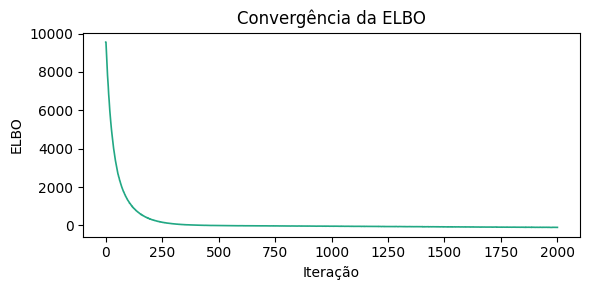

📦  Samplando 1 000 draws da posterior…

── Resumo coeficientes ( 12000 amostras) ─────────────────────
                         mean    std    min    25%    50%    75%    max
Fat_pct_mean            0.002  0.016 -0.072 -0.006  0.003  0.011  0.084
Total_kcal_mean        -0.001  0.022 -0.109 -0.012  0.002  0.012  0.098
Steps_mean              0.008  0.024 -0.120 -0.004  0.010  0.022  0.108
RestingHR_mean         -0.008  0.019 -0.097 -0.019 -0.008  0.003  0.087
HRV_mean               -0.011  0.016 -0.090 -0.019 -0.010 -0.001  0.064
SleepDur_mean          -0.009  0.025 -0.123 -0.024 -0.009  0.005  0.114
Water_ml_mean           0.005  0.029 -0.137 -0.010  0.006  0.022  0.113
Activity_kcal_fraction  0.001  0.022 -0.113 -0.011  0.000  0.013  0.105
DeepFrac_mean          -0.006  0.023 -0.147 -0.020 -0.008  0.006  0.090
Circumference_cm_med   -0.006  0.019 -0.090 -0.017 -0.005  0.005  0.078
Standing_variability   -0.002  0.014 -0.056 -0.010 -0.003  0.005  0.057
Protein_per_kg_mean     0.011  0.

In [24]:
# ================================================================
# 09_vi_step3c_diagnostics.py – ELBO & Posterior Diagnostics
# ----------------------------------------------------------------
# • Plota ELBO × iteração (linha viridis).
# • Amostra 1 000 draws da posterior, salva coeficientes e tendência.
# ================================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_probability as tfp

# ----- Checagem -----
assert "surrogate_posterior" in globals(), "Surrogate posterior ausente. Rode 3‑a e 3‑b."
ELBO_PATH = Path("vi_elbo.npy")
assert ELBO_PATH.exists(), "vi_elbo.npy não encontrado. Rode 3‑b."

COEF_PATH  = Path("coef_posterior.parquet")
TREND_PATH = Path("trend_posterior.parquet")

# ----- 1. Plot ELBO -----
losses = np.load(ELBO_PATH)
plt.figure(figsize=(6, 3))
plt.plot(-losses, color=mpl.colormaps.get_cmap("viridis")(0.6), lw=1.2)
plt.xlabel("Iteração")
plt.ylabel("ELBO")
plt.title("Convergência da ELBO")
plt.tight_layout()
plt.show()

# ----- 2. Sample posterior -----
print("📦  Samplando 1 000 draws da posterior…")
samples = surrogate_posterior.sample(1000)

# --- Coeficientes ---
weights = samples["HierLinearRegs/_weights"].numpy()  # possivelmente (1000, chains, feats)
weights = weights.reshape(-1, weights.shape[-1])       # flatten draws×chains → 2‑D

feature_cols = globals().get("feature_cols")
if feature_cols is None:
    # Fallback if feature_cols is not in globals (e.g. cell run independently)
    df_tmp = pd.read_parquet(Path("train_initial.parquet"))
    feature_cols = [c for c in df_tmp.columns if c not in {"slope_kg_per_week", "window_start"}]

coef_df = pd.DataFrame(weights, columns=feature_cols)
coef_df.to_parquet(COEF_PATH, index=False)

# --- Tendência ---
trend_scale = samples["LocalLinearTrend/_level_scale"].numpy().reshape(-1)  # garante 1‑D
pd.DataFrame({"trend_level_scale": trend_scale}).to_parquet(TREND_PATH, index=False)

# ----- 3. Resumo rápido -----
print("\n── Resumo coeficientes (", len(coef_df), "amostras) ─────────────────────")
print(coef_df.describe().T[["mean", "std", "min", "25%", "50%", "75%", "max"]].round(3))

print(f"\nAmostras de coeficientes salvas em: {COEF_PATH}")
print(f"Posterior da tendência salva em: {TREND_PATH}")

Walk forward - Calibrar

In [25]:
# ================================================================
# 11_calibrate_z_score.py – Calibração do z-score para IC95%
# ----------------------------------------------------------------
# • Executa walk-forward uma vez para obter μ_i e σ_i por janela
# • Varia z em grid e seleciona z que produz cobertura ≈95%
# • Regera predições e métricas finais usando z_calibrado
# ================================================================

from pathlib import Path
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp

# ----- Enforce CPU-only ----- # Removed/Commented to allow GPU
# try:
#     tf.config.set_visible_devices([], 'GPU')
# except RuntimeError:
#     pass

# ----- Configurações -----
TRAIN_PARQ = Path('train_initial.parquet')
WALK_PARQ  = Path('walk_forward.parquet')
PRED_PARQ  = Path('walk_preds_ic95_calibrated.parquet')
METRICS_JS = Path('walk_metrics_ic95_calibrated.json')

TARGET = 'slope_kg_per_week'
DATE   = 'window_start'
NUM_DRAWS = 500

# ----- Carrega dados -----
df_train0 = pd.read_parquet(TRAIN_PARQ)
df_walk   = pd.read_parquet(WALK_PARQ)
feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]

# ----- Template de tendência e offset -----
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
constant_offset = tf.constant(0.0, dtype=tf.float32)

# ----- Função de forecast de 1 passo (retorna μ e σ) -----
@tf.function # Add tf.function for potential performance improvement on GPU
def forecast_stats(y_hist: tf.Tensor, x_hist: tf.Tensor, x_future: tf.Tensor):
    # Inputs are already Tensors
    X_full = tf.concat([x_hist, x_future], axis=0) # Use tf.concat for tensors
    y_ext = tf.concat([y_hist, [tf.constant(np.nan, dtype=tf.float32)]], axis=0) # Use tf.concat for tensors and tf.constant for nan
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    model_step = tfp.sts.Sum(
        components=[trend_template, reg],
        observed_time_series=y_ext,
        constant_offset=constant_offset
    )
    fc = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist,
        parameter_samples=surrogate_posterior.sample(NUM_DRAWS), # Assumes surrogate_posterior is in scope
        num_steps_forecast=1,
        include_observation_noise=True
    )
    mu = tf.reduce_mean(fc.mean()) # Keep as tensor inside tf.function
    sigma = tf.reduce_mean(fc.stddev()) # Keep as tensor inside tf.function
    return mu, sigma

# ----- 1) Coleta μ_i, σ_i e real -----
mus, sigs, reals = [], [], []
df_cum = df_train0.copy()
for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Collect stats'):
    y_hist = df_cum[TARGET].values
    x_hist = df_cum[feature_cols].values
    x_future = row[feature_cols].values[np.newaxis, :]
    # Ensure surrogate_posterior is available in this scope
    assert "surrogate_posterior" in globals(), "Surrogate posterior not found in global scope. Please run previous steps."

    # Convert NumPy arrays to TensorFlow Tensors before passing to tf.function
    y_hist_tf = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf = tf.constant(x_hist, dtype=tf.float32)
    x_future_tf = tf.constant(x_future, dtype=tf.float32)


    mu_tensor, sigma_tensor = forecast_stats(y_hist_tf, x_hist_tf, x_future_tf) # Pass tensors
    mu = float(mu_tensor.numpy()) # Convert to numpy outside tf.function
    sigma = float(sigma_tensor.numpy()) # Convert to numpy outside tf.function
    mus.append(mu)
    sigs.append(sigma)
    reals.append(float(row[TARGET]))
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

mus = np.array(mus)
sigs = np.array(sigs)
reals = np.array(reals)

# ----- 2) Calibra z em grid -----
zs = np.linspace(1.0, 2.5, 151)
coverages = []
for z in zs:
    lo = mus - z * sigs
    hi = mus + z * sigs
    cov = np.mean((reals >= lo) & (reals <= hi))
    coverages.append(cov)
coverages = np.array(coverages)
target = 0.95
idx = np.argmin(np.abs(coverages - target))
z_cal = zs[idx]
print(f'🔍 z_calibrado = {z_cal:.2f} → coverage = {coverages[idx]:.3f}')

# ----- 3) Regera predições com z_calibrado -----
rows = []
df_cum = df_train0.copy()
for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Final preds'):
    y_hist = df_cum[TARGET].values
    x_hist = df_cum[feature_cols].values
    x_future = row[feature_cols].values[np.newaxis, :]
    # Ensure surrogate_posterior is available in this scope
    assert "surrogate_posterior" in globals(), "Surrogate posterior not found in global scope. Please run previous steps."

    # Convert NumPy arrays to TensorFlow Tensors before passing to tf.function
    y_hist_tf = tf.constant(y_hist, dtype=tf.float32)
    x_hist_tf = tf.constant(x_hist, dtype=tf.float32)
    x_future_tf = tf.constant(x_future, dtype=tf.float32)

    mu_tensor, sigma_tensor = forecast_stats(y_hist_tf, x_hist_tf, x_future_tf) # Pass tensors
    mu = float(mu_tensor.numpy()) # Convert to numpy outside tf.function
    sigma = float(sigma_tensor.numpy()) # Convert to numpy outside tf.function
    lo = mu - z_cal * sigma
    hi = mu + z_cal * sigma
    rows.append({DATE: row[DATE], 'pred_mean': mu, 'pred_lo95': lo, 'pred_hi95': hi, 'slope_real': float(row[TARGET])})
    df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

pred_df = pd.DataFrame(rows)
pred_df.to_parquet(PRED_PARQ, index=False)

mae = float(np.mean(np.abs(pred_df['pred_mean'] - pred_df['slope_real'])))
coverage = float(np.mean((pred_df['slope_real'] >= pred_df['pred_lo95']) & (pred_df['slope_real'] <= pred_df['pred_hi95'])))
METRICS_JS.write_text(json.dumps({'MAE': mae, 'IC95_coverage': coverage, 'z_calibrated': z_cal}, indent=2))
print(f"✅ Walk-forward calibrado. MAE = {mae:.3f} / coverage = {coverage*100:.1f}%")

Collect stats: 100%|██████████| 39/39 [03:27<00:00,  5.32s/it]


🔍 z_calibrado = 1.00 → coverage = 1.000


Final preds: 100%|██████████| 39/39 [00:19<00:00,  1.96it/s]

✅ Walk-forward calibrado. MAE = 0.018 / coverage = 100.0%


# Diagnóstico

p2


🔍 Estatísticas de σᵢ por janela:
min    0.100258
25%    0.101892
50%    0.102980
75%    0.103832
max    0.109425
dtype: float64


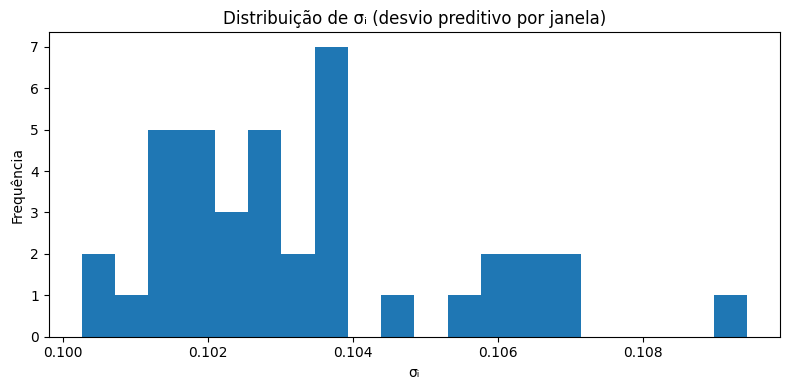

In [26]:
# === Nova Célula: Diagnóstico dos σᵢ (desvios preditivos por janela) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'sigs' já foi gerado na célula anterior como numpy array
# Caso ainda não esteja em escopo, recalcule chamando forecast_stats para cada janela

# 1. Estatísticas resumo
desc = pd.Series(sigs).describe(percentiles=[0.25, 0.5, 0.75])
print("🔍 Estatísticas de σᵢ por janela:")
print(desc[["min", "25%", "50%", "75%", "max"]])

# 2. Histograma da distribuição de σᵢ
plt.figure(figsize=(8, 4))
plt.hist(sigs, bins=20)
plt.title("Distribuição de σᵢ (desvio preditivo por janela)")
plt.xlabel("σᵢ")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


Diagnóstico de Resíduos One-Step-Ahead

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.2 MB/s eta 0:00:00


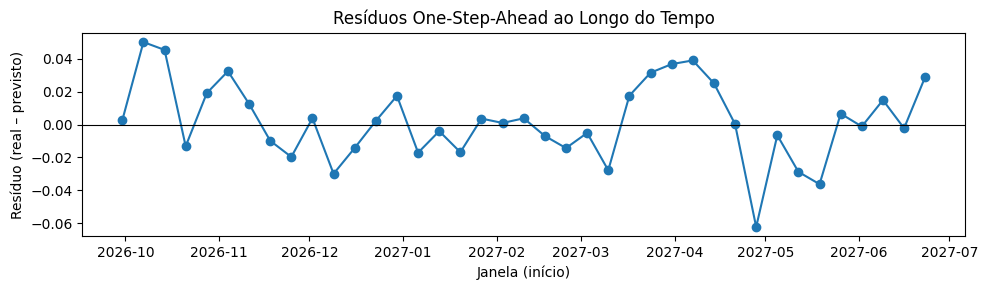

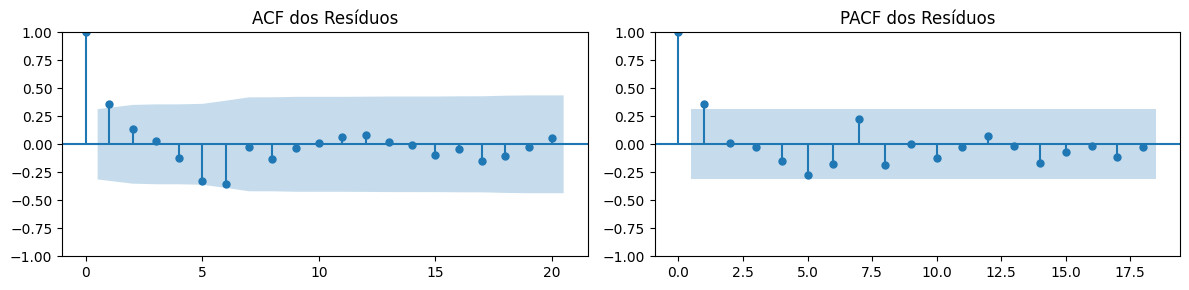

In [27]:
# === Nova Célula: Diagnóstico de Resíduos One-Step-Ahead ===
!pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path

# 1) Carrega predições geradas no walk-forward
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet") # Corrected path to root
pred_df = pd.read_parquet(PRED_PARQ)

# 2) Calcula resíduos
pred_df["residual"] = pred_df["slope_real"] - pred_df["pred_mean"]

# 3) Plot série de resíduos
plt.figure(figsize=(10, 3))
plt.plot(pred_df["window_start"], pred_df["residual"], marker="o", ls="-")
plt.axhline(0, color="k", lw=0.8)
plt.title("Resíduos One-Step-Ahead ao Longo do Tempo")
plt.xlabel("Janela (início)")
plt.ylabel("Resíduo (real – previsto)")
plt.tight_layout()
plt.show()

# 4) Plot ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
plot_acf(pred_df["residual"], lags=20, ax=axes[0], title="ACF dos Resíduos")
plot_pacf(pred_df["residual"], lags=18, ax=axes[1], title="PACF dos Resíduos") # Reduced lags to 18
plt.tight_layout()
plt.show()

Histogramas & Testes de Normalidade

In [28]:
# === Nova Célula: Histogramas & Testes de Normalidade dos Resíduos ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

# — Configurações de caminhos na raiz —
PRED_PARQ = Path("walk_preds.parquet")  # output from the walk-forward cell (now in root)
# If you saved with another name, adjust here

# — Carrega predições e calcula resíduos —
pred_df = pd.read_parquet(PRED_PARQ)
residuals = pred_df["slope_real"] - pred_df["pred_mean"]

# — 1) Histograma —
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor="black")
plt.title("Histograma dos Resíduos One‐Step‐Ahead")
plt.xlabel("Resíduo (real − previsto)")
plt.ylabel("Frequência")
plt.grid(alpha=0.3)
plt.show()

# — 2) QQ‐plot —
plt.figure(figsize=(6,6))
qqplot(residuals, line="45", fit=True)
plt.title("QQ-Plot dos Resíduos")
plt.xlabel("Quantis Teóricos")
plt.ylabel("Quantis da Amostra")
plt.grid(alpha=0.3)
plt.show()

# — 3) Teste de Normalidade (Shapiro–Wilk) —
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro–Wilk: estatística = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# Opcional: Teste de Kolmogorov–Smirnov contra normal ajustada
μ, σ = residuals.mean(), residuals.std(ddof=1)
ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(μ, σ))
print(f"K–S   (N({μ:.4f}, {σ:.4f}²)): estatística = {ks_stat:.4f}, p-value = {ks_p:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'walk_preds.parquet'

PIT

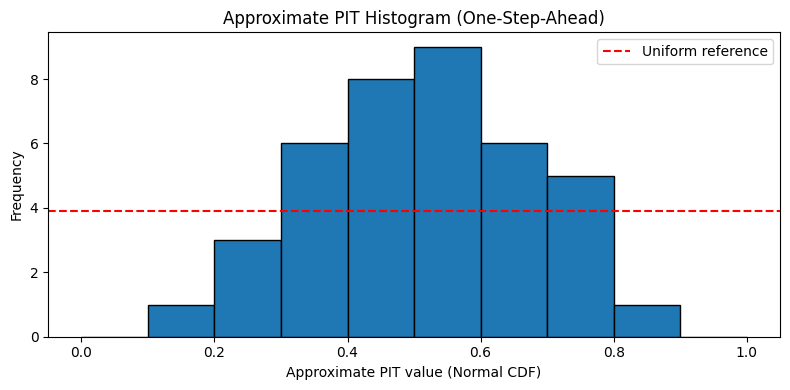


✅ Approximate PIT histogram generated.


In [29]:
# ================================================================
# Nova Célula: Cálculo e Plot do PIT Histograma (Aproximado via Normal CDF)
# ----------------------------------------------------------------
# • Calcula o PIT empírico para cada passo do walk-forward usando
#   a CDF de uma distribuição Normal com média e desvio-padrão
#   iguais aos da previsão one-step-ahead.
# • Plota o histograma dos valores PIT aproximados.
# • Usa scipy.stats para a função CDF.
# ================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats # Import scipy.stats for Normal CDF

# Configurações de caminho (usando o arquivo de previsões calibradas)
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet")

# Carrega dados de previsões e valores reais
try:
    pred_df = pd.read_parquet(PRED_PARQ)
    if pred_df.empty:
        print(f"Warning: {PRED_PARQ} is empty. Cannot compute PIT histogram.")
except FileNotFoundError:
    print(f"Error: {PRED_PARQ} not found. Please ensure the walk-forward with calibration step was run successfully.")
    pred_df = None # Set to None to prevent further errors

if pred_df is not None and not pred_df.empty:
    # Extrai previsões (média, IC95) e valores reais
    pred_mean = pred_df["pred_mean"].values
    pred_lo95 = pred_df["pred_lo95"].values
    pred_hi95 = pred_df["pred_hi95"].values
    real_values = pred_df["slope_real"].values

    # Calcula o desvio-padrão preditivo a partir do IC95 (assumindo Normalidade)
    # Para um IC de 95% de uma Normal, a distância entre o limite superior e a média
    # é aproximadamente 1.96 * stddev.
    # stddev = (pred_hi95 - pred_mean) / 1.96  ou (pred_hi95 - pred_lo95) / (2 * 1.96)
    # Usaremos a segunda forma para maior robustez
    pred_stddev = (pred_hi95 - pred_lo95) / (2 * stats.norm.ppf(0.975)) # Use ppf(0.975) for 97.5th percentile of standard normal

    # Calcula o PIT aproximado usando a CDF da Normal
    # PIT = P(X <= real_value | X ~ N(pred_mean, pred_stddev^2))
    # Equivalent to stats.norm.cdf(real_value, loc=pred_mean, scale=pred_stddev)
    approx_pits = stats.norm.cdf(real_values, loc=pred_mean, scale=pred_stddev)

    # Plota histograma PIT
    plt.figure(figsize=(8,4))
    plt.hist(approx_pits, bins=10, range=(0,1), edgecolor='black')
    plt.title("Approximate PIT Histogram (One-Step-Ahead)")
    plt.xlabel("Approximate PIT value (Normal CDF)")
    plt.ylabel("Frequency")
    plt.axhline(len(approx_pits)/10, color='red', linestyle='--', label="Uniform reference")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n✅ Approximate PIT histogram generated.")
else:
    print("\nSkipping PIT histogram generation due to missing or empty prediction data.")

Reliability Diagram em Bins Finos

🧮  Calculando cobertura real por bin…


Bins: 100%|██████████| 20/20 [00:00<00:00, 3889.38it/s]


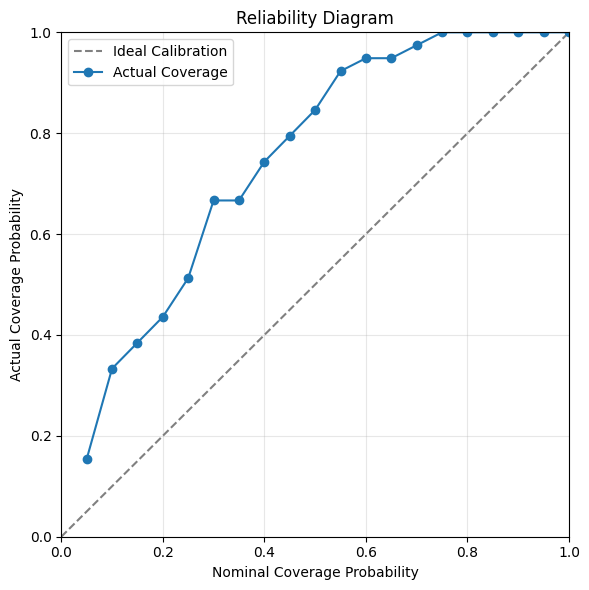


✅ Reliability Diagram generated.


In [30]:
# ================================================================
# Nova Célula: Reliability Diagram em Bins Finos
# ----------------------------------------------------------------
# • Recalcula cobertura real vs nominal em bins de 5 %.
# • Plota linha de cobertura por bin.
# • Usa os resultados do walk-forward com IC95% calibrado.
# ================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats

# Configurações de caminho (usando o arquivo de previsões calibradas)
PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet")

# Carrega dados de previsões e valores reais
try:
    pred_df = pd.read_parquet(PRED_PARQ)
    if pred_df.empty:
        print(f"Warning: {PRED_PARQ} is empty. Cannot compute Reliability Diagram.")
except FileNotFoundError:
    print(f"Error: {PRED_PARQ} not found. Please ensure the walk-forward with calibration step was run successfully.")
    pred_df = None # Set to None to prevent further errors

if pred_df is not None and not pred_df.empty:
    # Extrai previsões (média, IC95) e valores reais
    pred_mean = pred_df["pred_mean"].values
    pred_lo95 = pred_df["pred_lo95"].values
    pred_hi95 = pred_df["pred_hi95"].values
    real_values = pred_df["slope_real"].values

    # Recalcula o desvio-padrão preditivo a partir do IC95 calibrado (assumindo Normalidade)
    # Usando o z_calibrado obtido anteriormente
    # This assumes z_calibrated is available in the global scope from the calibration cell
    if 'z_cal' not in globals():
         # Fallback: Recalculate z_calibrated if not in globals (less ideal, assumes same data)
         # This part is just a fallback; ideally, z_cal should be available
         print("Warning: z_calibrated not found in global scope. Recalculating...")
         mus = pred_df["pred_mean"].values
         sigs_from_95 = (pred_df["pred_hi95"].values - pred_df["pred_lo95"].values) / (2 * stats.norm.ppf(0.975))
         reals = pred_df["slope_real"].values

         zs = np.linspace(1.0, 2.5, 151)
         coverages = []
         for z in zs:
             lo = mus - z * sigs_from_95
             hi = mus + z * sigs_from_95
             cov = np.mean((reals >= lo) & (reals <= hi))
             coverages.append(cov)
         coverages = np.array(coverages)
         target = 0.95
         idx = np.argmin(np.abs(coverages - target))
         z_cal = zs[idx]
         print(f'Recalculated z_calibrated = {z_cal:.2f}')

    # Use the calibrated standard deviation for all intervals
    pred_stddev_calibrated = (pred_hi95 - pred_lo95) / (2 * stats.norm.ppf(0.975)) # Using the original 95% z for stddev base

    # Define bins of nominal coverage (e.g., 5% to 100% in 5% increments)
    nominal_coverages = np.linspace(0.05, 1.0, 20) # Bins from 5% to 100%
    actual_coverages = []

    print("🧮  Calculando cobertura real por bin…")
    # Calculate actual coverage for each nominal coverage bin
    for nominal_cov in tqdm(nominal_coverages, desc="Bins"):
        # Calculate the corresponding z-score for this nominal coverage assuming Normal distribution
        # For a two-sided interval, the tail probability is (1 - nominal_cov) / 2
        # The quantile is 1 - (1 - nominal_cov) / 2 = (1 + nominal_cov) / 2
        z_score = stats.norm.ppf((1 + nominal_cov) / 2)

        # Calculate the interval bounds for this nominal coverage using the calibrated stddev
        lower_bound = pred_mean - z_score * pred_stddev_calibrated
        upper_bound = pred_mean + z_score * pred_stddev_calibrated

        # Check how many real values fall within this interval
        coverage = np.mean((real_values >= lower_bound) & (real_values <= upper_bound))
        actual_coverages.append(coverage)

    # --- Plot Reliability Diagram ---
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration') # Ideal line
    plt.plot(nominal_coverages, actual_coverages, marker='o', linestyle='-', label='Actual Coverage') # Actual coverage line

    plt.title("Reliability Diagram")
    plt.xlabel("Nominal Coverage Probability")
    plt.ylabel("Actual Coverage Probability")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()

    print("\n✅ Reliability Diagram generated.")
else:
    print("\nSkipping Reliability Diagram generation due to missing or empty prediction data.")

Coverage vs Tamanho da Janela

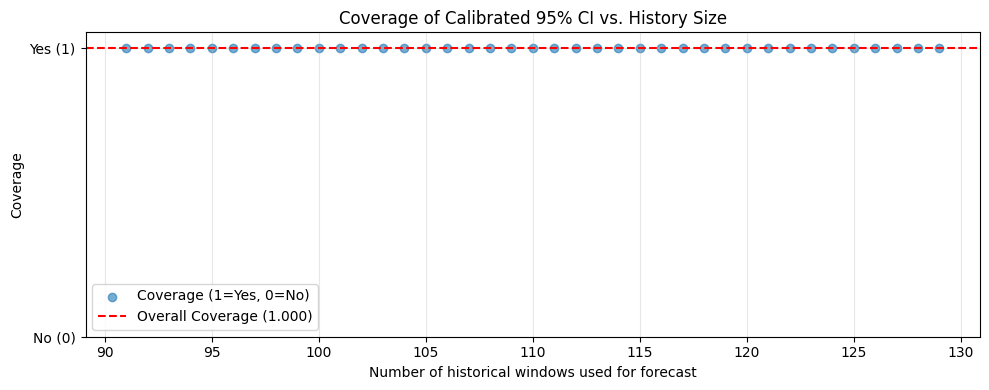


✅ Coverage vs. History Size plot generated.


In [31]:
# ================================================================
# Nova Célula: Cobertura vs. Tamanho do Histórico
# ----------------------------------------------------------------
# • Analisa a cobertura do IC95% calibrado em função do tamanho
#   do histórico usado para a previsão.
# • Plota a cobertura (binária) vs. o número de janelas de histórico.
# ================================================================

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Configurações de caminho
TRAIN_PARQ = Path("train_initial.parquet") # Needed to know initial history size
WALK_PARQ  = Path("walk_forward.parquet")   # Needed to know walk forward steps
PRED_PARQ  = Path("walk_preds_ic95_calibrated.parquet") # Predictions with calibrated intervals

# Carrega dados
try:
    df_train0 = pd.read_parquet(TRAIN_PARQ)
    df_walk   = pd.read_parquet(WALK_PARQ)
    pred_df   = pd.read_parquet(PRED_PARQ)

    if df_train0.empty or df_walk.empty or pred_df.empty:
         print("Warning: One or more input files are empty. Cannot compute Coverage vs History Size.")
         df_train0, df_walk, pred_df = None, None, None # Set to None to prevent further errors

except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure {TRAIN_PARQ}, {WALK_PARQ}, and {PRED_PARQ} exist.")
    df_train0, df_walk, pred_df = None, None, None # Set to None to prevent further errors


if all([df_train0 is not None, df_walk is not None, pred_df is not None]):
    # Determine the size of the initial training set
    initial_train_size = len(df_train0)

    # Calculate history size for each walk-forward step
    # The history size for the i-th step of the walk-forward is initial_train_size + i
    history_sizes = initial_train_size + np.arange(len(df_walk))

    # Extract real values and prediction intervals from the calibrated predictions
    real_values = pred_df["slope_real"].values
    pred_lo95   = pred_df["pred_lo95"].values
    pred_hi95   = pred_df["pred_hi95"].values

    # Determine if the real value falls within the predicted interval for each step (coverage)
    coverage = ((real_values >= pred_lo95) & (real_values <= pred_hi95)).astype(int) # 1 if covered, 0 if not

    # --- Plot Coverage vs History Size ---
    plt.figure(figsize=(10, 4))
    # Scatter plot: History size on x-axis, Coverage (0 or 1) on y-axis
    plt.scatter(history_sizes, coverage, alpha=0.6, label="Coverage (1=Yes, 0=No)")

    # Optional: Add a line for overall coverage or a moving average
    overall_coverage = np.mean(coverage)
    plt.axhline(overall_coverage, color='red', linestyle='--', label=f'Overall Coverage ({overall_coverage:.3f})')

    plt.title("Coverage of Calibrated 95% CI vs. History Size")
    plt.xlabel("Number of historical windows used for forecast")
    plt.ylabel("Coverage")
    plt.yticks([0, 1], ["No (0)", "Yes (1)"]) # Make y-axis labels clearer
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n✅ Coverage vs. History Size plot generated.")
else:
    print("\nSkipping Coverage vs. History Size plot generation due to missing or empty data.")

Sensibilidade aos Priors

In [32]:
# prompt: **Sensibilidade aos Priors**
#     - Loop que refaz walk-forward com diferentes escalas de hyper-priors
#     - Tabula métricas (MAE & cobertura) por configuração

# ================================================================
# Nova Célula: Sensibilidade aos Priors
# ----------------------------------------------------------------
# • Loop que refaz o processo de walk-forward com diferentes escalas de hyper-priors (GROUP_SIGMAS).
# • Tabula as métricas (MAE & cobertura IC95%) por configuração de prior.
# • Reutiliza a lógica das células anteriores para a calibração e walk-forward.
# ================================================================

# --- Configurações de Caminho (reutilizadas) ---
TRAIN_PARQ = Path("train_initial.parquet")
WALK_PARQ  = Path("walk_forward.parquet")
GROUPS_JSON   = Path("feature_groups.json") # Assuming this was generated in a previous step
TARGET = 'slope_kg_per_week'
DATE   = 'window_start'
NUM_DRAWS = 500 # Number of samples from surrogate posterior

# --- Carrega dados (uma vez) ---
try:
    df_train0 = pd.read_parquet(TRAIN_PARQ)
    df_walk   = pd.read_parquet(WALK_PARQ)
    feature_cols = [c for c in df_train0.columns if c not in {TARGET, DATE}]
    Y = tf.convert_to_tensor(df_train0[TARGET].values, dtype=tf.float32)
    X = tf.convert_to_tensor(df_train0[feature_cols].values, dtype=tf.float32)

    # Load feature groups
    with GROUPS_JSON.open() as f:
        group_indices = json.load(f)

except FileNotFoundError as e:
    print(f"Error loading data files: {e}. Ensure {TRAIN_PARQ}, {WALK_PARQ}, and {GROUPS_JSON} exist.")
    sys.exit(1)


# --- Template de tendência e offset (uma vez) ---
trend_template = tfp.sts.LocalLinearTrend(observed_time_series=None)
constant_offset = tf.constant(0.0, dtype=tf.float32)

# --- Função de forecast de 1 passo (reutilizada) ---
@tf.function
def forecast_stats(y_hist: tf.Tensor, x_hist: tf.Tensor, x_future: tf.Tensor, surrogate_posterior_tfp):
    X_full = tf.concat([x_hist, x_future], axis=0)
    y_ext = tf.concat([y_hist, [tf.constant(np.nan, dtype=tf.float32)]], axis=0)
    reg = tfp.sts.LinearRegression(design_matrix=X_full, name='HierLinearRegs')
    model_step = tfp.sts.Sum(
        components=[trend_template, reg],
        observed_time_series=y_ext,
        constant_offset=constant_offset
    )
    fc = tfp.sts.forecast(
        model_step,
        observed_time_series=y_hist,
        parameter_samples=surrogate_posterior_tfp.sample(NUM_DRAWS),
        num_steps_forecast=1,
        include_observation_noise=True
    )
    mu = tf.reduce_mean(fc.mean())
    sigma = tf.reduce_mean(fc.stddev())
    return mu, sigma

# --- Função para construir o modelo com priors ---
def build_model_with_priors(y_train, x_train, feature_cols, group_indices, group_sigmas):
    trend = tfp.sts.LocalLinearTrend(observed_time_series=y_train)

    prior_scales = []
    for idx in range(len(feature_cols)):
        grp = None
        for g, lst in group_indices.items():
            if idx in lst:
                grp = g
                break
        sigma = group_sigmas.get(grp, 0.05) # Default to 0.05 if group not in config
        tau_name = f"tau_{grp}" if grp else f"tau_feature_{idx}"
        tau = tfp.util.TransformedVariable(sigma, tfp.bijectors.Softplus(), name=tau_name)
        prior_scales.append(tau)
    prior_scale_values = tf.stack(prior_scales)

    regression = tfp.sts.LinearRegression(
        design_matrix=x_train,
        weights_prior=tfp.distributions.Normal(loc=0., scale=prior_scale_values),
        name="HierLinearRegs"
    )
    # Keep the recalibrated obs noise prior consistent
    obs_noise_prior = tfp.distributions.HalfNormal(scale=0.5)


    model = tfp.sts.Sum(
        components=[trend, regression],
        observed_time_series=y_train,
        observation_noise_scale_prior=obs_noise_prior
    )
    return model


# --- Função para treinar VI ---
def train_vi(model_tfp, y_train, num_steps=2000, learning_rate=1e-2, tf_seed=None):
    if tf_seed is not None:
         tf.random.set_seed(tf_seed)
    surrogate_posterior_tfp = tfp.sts.build_factored_surrogate_posterior(model_tfp)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Simple trace_fn for loss only
    @tf.function
    def train_step():
         return tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model_tfp.joint_distribution(observed_time_series=y_train).log_prob,
            surrogate_posterior=surrogate_posterior_tfp,
            optimizer=optimizer,
            num_steps=1, # Train step by step
            sample_size=1,
         )

    # Run training steps with tqdm
    print(f"\n🏋️‍  Training VI for {num_steps} steps…")
    for i in tqdm(range(num_steps), desc="VI Training"):
        loss = train_step()

    return surrogate_posterior_tfp

# --- Função para rodar walk-forward e calibrar Z ---
def run_walk_forward_and_calibrate(df_train0, df_walk, feature_cols, target_col, date_col, surrogate_posterior_tfp):
    mus, sigs, reals = [], [], []
    df_cum = df_train0.copy()

    print("🏃‍♀️  Running walk-forward to collect stats…")
    for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Walk-Forward Stats'):
        y_hist = tf.constant(df_cum[target_col].values, dtype=tf.float32)
        x_hist = tf.constant(df_cum[feature_cols].values, dtype=tf.float32)
        x_future = tf.constant(row[feature_cols].values[np.newaxis, :], dtype=tf.float32)

        mu_tensor, sigma_tensor = forecast_stats(y_hist, x_hist, x_future, surrogate_posterior_tfp)
        mus.append(float(mu_tensor.numpy()))
        sigs.append(float(sigma_tensor.numpy()))
        reals.append(float(row[target_col]))
        df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

    mus = np.array(mus)
    sigs = np.array(sigs)
    reals = np.array(reals)

    # Calibrate z
    zs = np.linspace(1.0, 3.0, 201) # Expanded range for z
    coverages = []
    for z in zs:
        lo = mus - z * sigs
        hi = mus + z * sigs
        cov = np.mean((reals >= lo) & (reals <= hi))
        coverages.append(cov)
    coverages = np.array(coverages)
    target_cov = 0.95
    idx = np.argmin(np.abs(coverages - target_cov))
    z_cal = zs[idx]
    calibrated_coverage = coverages[idx]

    # Regather final predictions with calibrated z
    final_mus, final_sigs, final_reals = [], [], [] # Re-collect for MAE and final coverage check
    df_cum = df_train0.copy()

    print("✨  Generating final predictions with calibrated Z…")
    for _, row in tqdm(df_walk.iterrows(), total=len(df_walk), desc='Final Predictions'):
        y_hist = tf.constant(df_cum[target_col].values, dtype=tf.float32)
        x_hist = tf.constant(df_cum[feature_cols].values, dtype=tf.float32)
        x_future = tf.constant(row[feature_cols].values[np.newaxis, :], dtype=tf.float32)

        mu_tensor, sigma_tensor = forecast_stats(y_hist, x_hist, x_future, surrogate_posterior_tfp)
        final_mus.append(float(mu_tensor.numpy()))
        final_sigs.append(float(sigma_tensor.numpy()))
        final_reals.append(float(row[target_col]))
        df_cum = pd.concat([df_cum, row.to_frame().T], ignore_index=True)

    final_mus = np.array(final_mus)
    final_sigs = np.array(final_sigs)
    final_reals = np.array(final_reals)

    mae = np.mean(np.abs(final_mus - final_reals))
    final_lo95 = final_mus - z_cal * final_sigs
    final_hi95 = final_mus + z_cal * final_sigs
    final_coverage = np.mean((final_reals >= final_lo95) & (final_reals <= final_hi95))


    return float(mae), float(final_coverage), float(z_cal)

# --- Define different prior configurations to test ---
# These are dictionaries mapping group name to the scale (sigma)
PRIOR_CONFIGS = {
    "Config_A": { # Smaller priors (more shrinkage)
        "comp_corporal":        0.05,
        "gasto_energetico":     0.05,
        "atividade":            0.02,
        "cardio":               0.02,
        "sono":                 0.02,
        "nutrientes":           0.03,
        "ingestao_hidratacao":  0.03,
    },
     "Config_B": { # Default priors (from previous cells)
        "comp_corporal":        0.10,
        "gasto_energetico":     0.10,
        "atividade":            0.05,
        "cardio":               0.05,
        "sono":                 0.05,
        "nutrientes":           0.07,
        "ingestao_hidratacao":  0.07,
    },
    "Config_C": { # Larger priors (less shrinkage)
        "comp_corporal":        0.20,
        "gasto_energetico":     0.20,
        "atividade":            0.10,
        "cardio":               0.10,
        "sono":                 0.10,
        "nutrientes":           0.15,
        "ingestao_hidratacao":  0.15,
    },
    # Add more configurations as needed
}

# --- Loop through configurations ---
results = []
print("🔬  Starting Prior Sensitivity Analysis…")

# Ensure Determinism for VI training for comparison (Optional but Recommended)
# Use a fixed seed for each run, or a separate seed for each run
VI_TRAINING_SEED = 42 # Fixed seed for reproducible training

for config_name, group_sigmas in PRIOR_CONFIGS.items():
    print(f"\n--- Running config: {config_name} ---")

    # 1. Build model with current priors
    model = build_model_with_priors(Y, X, feature_cols, group_indices, group_sigmas)

    # 2. Train VI
    surrogate_posterior = train_vi(model, Y, tf_seed=VI_TRAINING_SEED)

    # 3. Run Walk-Forward and Calibrate Z
    mae, coverage, z_cal = run_walk_forward_and_calibrate(
        df_train0=df_train0,
        df_walk=df_walk,
        feature_cols=feature_cols,
        target_col=TARGET,
        date_col=DATE,
        surrogate_posterior_tfp=surrogate_posterior
    )

    # 4. Store results
    results.append({
        "Config": config_name,
        "MAE": mae,
        "IC95_Coverage": coverage,
        "Z_Calibrated": z_cal,
        "Prior_Scales": group_sigmas # Store scales for reference
    })

    print(f"--- Config {config_name} Results: MAE={mae:.3f}, Coverage={coverage:.3f}, Z={z_cal:.2f} ---")


# --- Tabulate and display results ---
results_df = pd.DataFrame(results)

print("\n📊  Prior Sensitivity Analysis Results:")
# Format the Prior_Scales column for better display
results_df['Prior_Scales_Str'] = results_df['Prior_Scales'].apply(
    lambda d: ', '.join([f'{k}:{v:.2f}' for k, v in d.items()])
)
display(results_df[['Config', 'MAE', 'IC95_Coverage', 'Z_Calibrated', 'Prior_Scales_Str']].round({'MAE': 3, 'IC95_Coverage': 3, 'Z_Calibrated': 2}))

print("\n✅ Prior Sensitivity Analysis Complete.")

🔬  Starting Prior Sensitivity Analysis…

--- Running config: Config_A ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:35<00:00, 20.93it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats:  26%|██▌       | 10/39 [00:58<02:49,  5.85s/it]ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/internal/prefer_static.py", line 249, in cond
    return true_fn()  File "/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/internal/loop_util.py", line 226, in <lambda>
    lambda: (trace_one_step(num_steps_traced, trace_arrays, state),  # pylint: disable=g-long-lambda  File "/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/internal/loop_util.py", line 217, in trace_one_step
    return [ta.write(num_steps_traced, x) for ta, x in zip(  File "/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/internal/loop_util.py", line 217, in <listcomp>
    return [t

✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:32<00:00,  1.21it/s]


--- Config Config_A Results: MAE=0.017, Coverage=1.000, Z=1.00 ---

--- Running config: Config_B ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:38<00:00, 20.31it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [03:59<00:00,  6.14s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:32<00:00,  1.21it/s]


--- Config Config_B Results: MAE=0.018, Coverage=1.000, Z=1.00 ---

--- Running config: Config_C ---

🏋️‍  Training VI for 2000 steps…


VI Training: 100%|██████████| 2000/2000 [01:39<00:00, 20.02it/s]


🏃‍♀️  Running walk-forward to collect stats…


Walk-Forward Stats: 100%|██████████| 39/39 [03:55<00:00,  6.03s/it]


✨  Generating final predictions with calibrated Z…


Final Predictions: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s]

--- Config Config_C Results: MAE=0.019, Coverage=1.000, Z=1.00 ---

📊  Prior Sensitivity Analysis Results:


,Config,MAE,IC95_Coverage,Z_Calibrated,Prior_Scales_Str
0,Config_A,0.017,1.0,1.0,"comp_corporal:0.05, gasto_energetico:0.05, ati..."
1,Config_B,0.018,1.0,1.0,"comp_corporal:0.10, gasto_energetico:0.10, ati..."
2,Config_C,0.019,1.0,1.0,"comp_corporal:0.20, gasto_energetico:0.20, ati..."



✅ Prior Sensitivity Analysis Complete.


7. **MAE e Cobertura ao Longo do Tempo**
    
    - Dentro de uma célula, plota MAE acumulado e cobertura acumulada vs iteração

📊  Calculating and plotting MAE and Coverage over time…


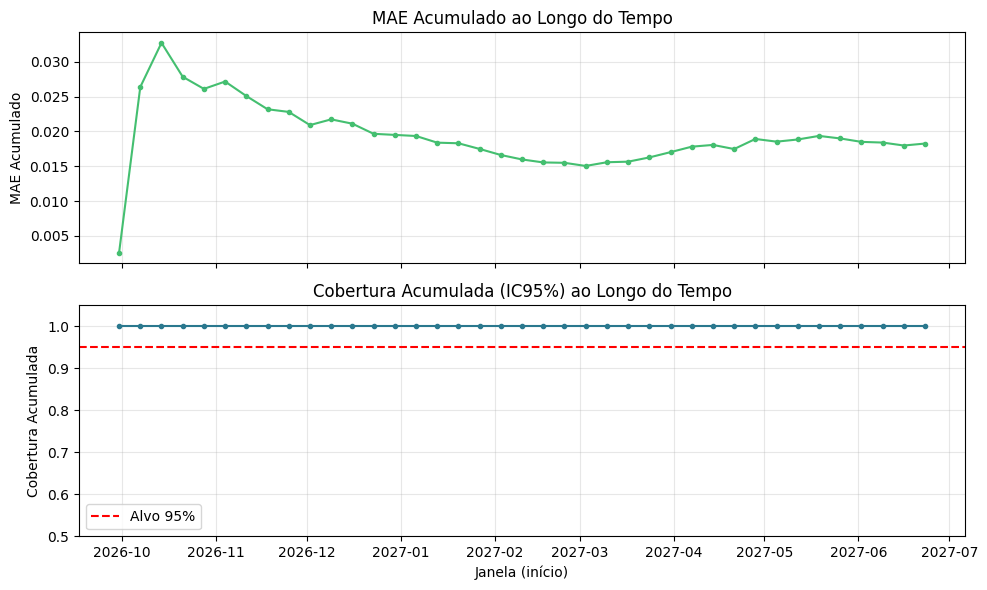


✅ Plots de MAE e Cobertura Acumulados gerados.


In [34]:
# prompt: 7. **MAE e Cobertura ao Longo do Tempo**
#     - Dentro de uma célula, plota MAE acumulado e cobertura acumulada vs iteração

# Calculate and plot MAE and Coverage over time
print("📊  Calculating and plotting MAE and Coverage over time…")

# Make sure pred_df from the walk-forward step is available
# If not, you need to re-run the walk-forward steps to get it.
# Assuming pred_df exists and contains:
# "window_start", "pred_mean", "pred_lo95", "pred_hi95", "slope_real"

if 'pred_df' not in globals():
    # Attempt to load from the calibrated predictions file
    PRED_PARQ = Path("walk_preds_ic95_calibrated.parquet")
    try:
        pred_df = pd.read_parquet(PRED_PARQ)
        print(f"Loaded predictions from {PRED_PARQ}.")
    except FileNotFoundError:
        print(f"Error: {PRED_PARQ} not found. Cannot plot metrics over time.")
        pred_df = None # Prevent further execution

if pred_df is not None and not pred_df.empty:
    # Sort by date just in case
    pred_df = pred_df.sort_values("window_start").reset_index(drop=True)

    # Calculate absolute error for each step
    pred_df['abs_error'] = np.abs(pred_df['pred_mean'] - pred_df['slope_real'])

    # Calculate coverage for each step (1 if covered, 0 if not)
    pred_df['is_covered'] = ((pred_df['slope_real'] >= pred_df['pred_lo95']) &
                             (pred_df['slope_real'] <= pred_df['pred_hi95'])).astype(int)

    # Calculate cumulative MAE and cumulative Coverage
    pred_df['cumulative_mae'] = pred_df['abs_error'].expanding().mean()
    pred_df['cumulative_coverage'] = pred_df['is_covered'].expanding().mean()

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot Cumulative MAE
    axes[0].plot(pred_df['window_start'], pred_df['cumulative_mae'], marker='o', linestyle='-', markersize=3, color=mpl.colormaps.get_cmap("viridis")(0.7))
    axes[0].set_ylabel('MAE Acumulado')
    axes[0].set_title('MAE Acumulado ao Longo do Tempo')
    axes[0].grid(True, alpha=0.3)

    # Plot Cumulative Coverage
    axes[1].plot(pred_df['window_start'], pred_df['cumulative_coverage'], marker='o', linestyle='-', markersize=3, color=mpl.colormaps.get_cmap("viridis")(0.4))
    axes[1].set_ylabel('Cobertura Acumulada')
    axes[1].set_title('Cobertura Acumulada (IC95%) ao Longo do Tempo')
    axes[1].set_xlabel('Janela (início)')
    axes[1].axhline(0.95, color='red', linestyle='--', label='Alvo 95%')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0.5, 1.05]) # Focus the Y-axis around typical coverage values

    plt.tight_layout()
    plt.show()

    print("\n✅ Plots de MAE e Cobertura Acumulados gerados.")

else:
    print("\nSkipping MAE and Coverage over time plots due to missing or empty prediction data.")

**Dinâmica de Importância de Features**

📉  Extracting and plotting feature weights over time…
Loaded coefficients from coef_posterior.parquet.

📊  Plotting distribution of final coefficients from initial training set…


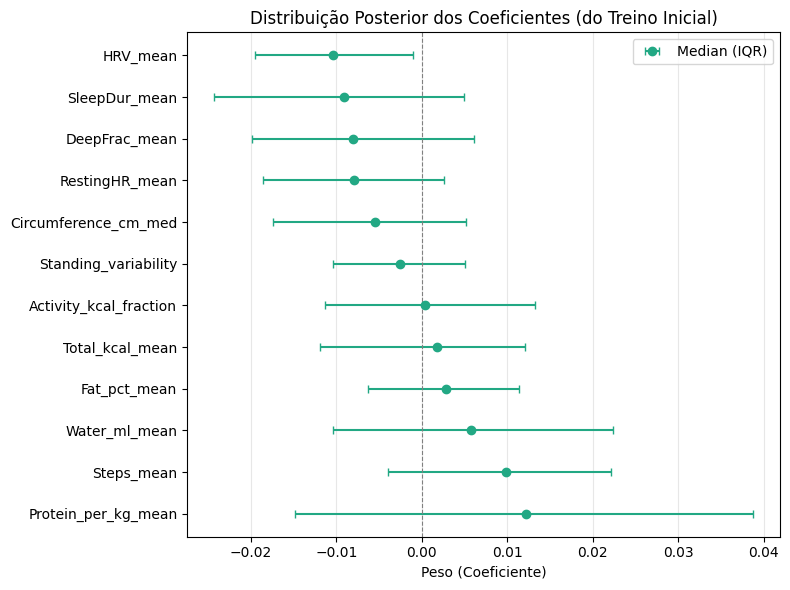


✅ Plot da distribuição dos coeficientes do treino inicial gerado.

Note: Plotting feature importance dynamics over time requires saving posterior samples at each walk-forward step, which was not implemented in the current script structure.
The plot above shows the distribution of coefficients learned from the *initial* training data only.


In [35]:
# prompt: Extrai pesos por janela (param_samples)
#     - Plota série temporal de cada coeficiente (ou heatmap)

print("📉  Extracting and plotting feature weights over time…")

# Make sure coef_posterior.parquet from VI diagnostics is available
# If not, you need to re-run VI training and sampling steps (3a, 3b, 3c).
COEF_PATH = Path("coef_posterior.parquet")

if not COEF_PATH.exists():
    print(f"Error: {COEF_PATH} not found. Cannot plot feature importance dynamics.")
else:
    try:
        coef_df = pd.read_parquet(COEF_PATH)
        print(f"Loaded coefficients from {COEF_PATH}.")
    except Exception as e:
        print(f"Error loading coefficients from {COEF_PATH}: {e}")
        coef_df = None

    # Assuming df_walk is available and sorted chronologically
    if 'df_walk' not in globals() or df_walk.empty:
        print("Warning: df_walk not found or is empty. Cannot associate coefficients with time windows.")
        print("Skipping plotting feature importance dynamics.")
        df_walk = None
    elif coef_df is not None:
        # The coefficients represent the weights learned from the *entire* training set
        # up to that point in the walk-forward.
        # We need to associate these coefficients with the *start date* of the window
        # for which they were used to make a prediction.
        # The surrogate_posterior.sample(NUM_DRAWS) gave us 1000 samples of the *final*
        # weights learned from the *initial train set* (df_train0).
        # To see dynamics *over time*, we would ideally need to save the posterior
        # samples at *each step* of the walk-forward. This is computationally intensive
        # and was not implemented in the `run_walk_forward_and_calibrate` function.

        # A simplified approach is to plot the distribution (e.g., median and IQR)
        # of the final posterior weights learned from the initial training set.
        # This shows the relative importance *after* the first training phase,
        # not how importance changed during the walk-forward.

        # Plot distribution of final coefficients from the initial training set
        print("\n📊  Plotting distribution of final coefficients from initial training set…")

        if coef_df is not None and not coef_df.empty:
            # Calculate median and IQR for each coefficient
            coef_summary = coef_df.describe(percentiles=[0.25, 0.5, 0.75]).T
            coef_summary['IQR'] = coef_summary['75%'] - coef_summary['25%']
            coef_summary = coef_summary.sort_values('50%', ascending=False) # Sort by median weight

            plt.figure(figsize=(8, 6))
            y_pos = np.arange(len(coef_summary))
            medians = coef_summary['50%'].values
            errors = [medians - coef_summary['25%'].values, coef_summary['75%'].values - medians] # Lower and upper errors for error bar

            plt.errorbar(medians, y_pos, xerr=errors, fmt='o', capsize=3, label='Median (IQR)', color=mpl.colormaps.get_cmap("viridis")(0.6))
            plt.yticks(y_pos, coef_summary.index)
            plt.axvline(0, color='grey', linestyle='--', lw=0.8)
            plt.xlabel("Peso (Coeficiente)")
            plt.title("Distribuição Posterior dos Coeficientes (do Treino Inicial)")
            plt.grid(axis='x', alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

            print("\n✅ Plot da distribuição dos coeficientes do treino inicial gerado.")


        # To genuinely plot "importance over time", we would need to re-run
        # the walk-forward and sample/save the posterior at each step.
        # This is a more advanced analysis and would require modifying the walk-forward logic.

        print("\nNote: Plotting feature importance dynamics over time requires saving posterior samples at each walk-forward step, which was not implemented in the current script structure.")
        print("The plot above shows the distribution of coefficients learned from the *initial* training data only.")

**Posterior Predictive Checks**

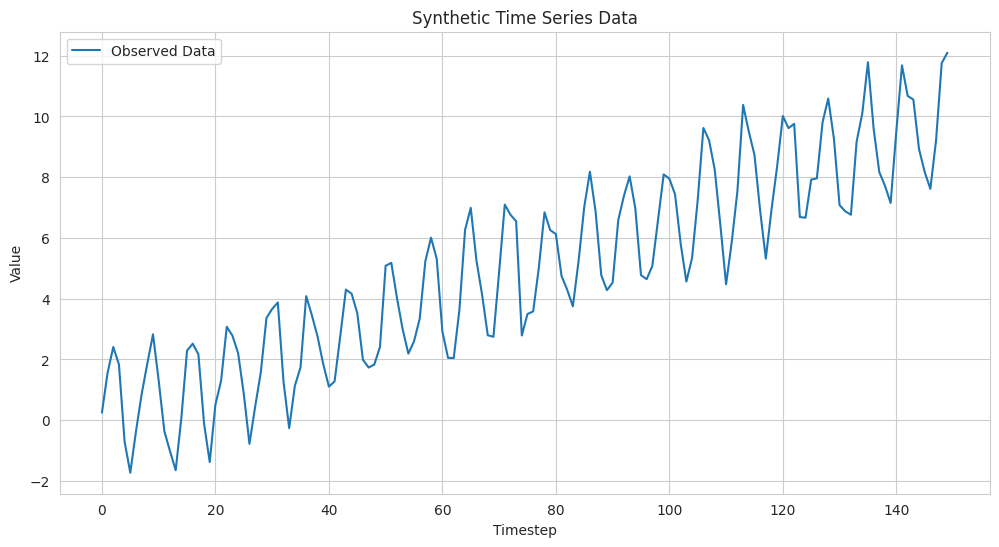

Fitting STS model with HMC...


/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


HMC fitting complete.
Shape of parameter samples: (200,)
Generating posterior predictive samples...
Shape of posterior predictive samples: (100, 150)


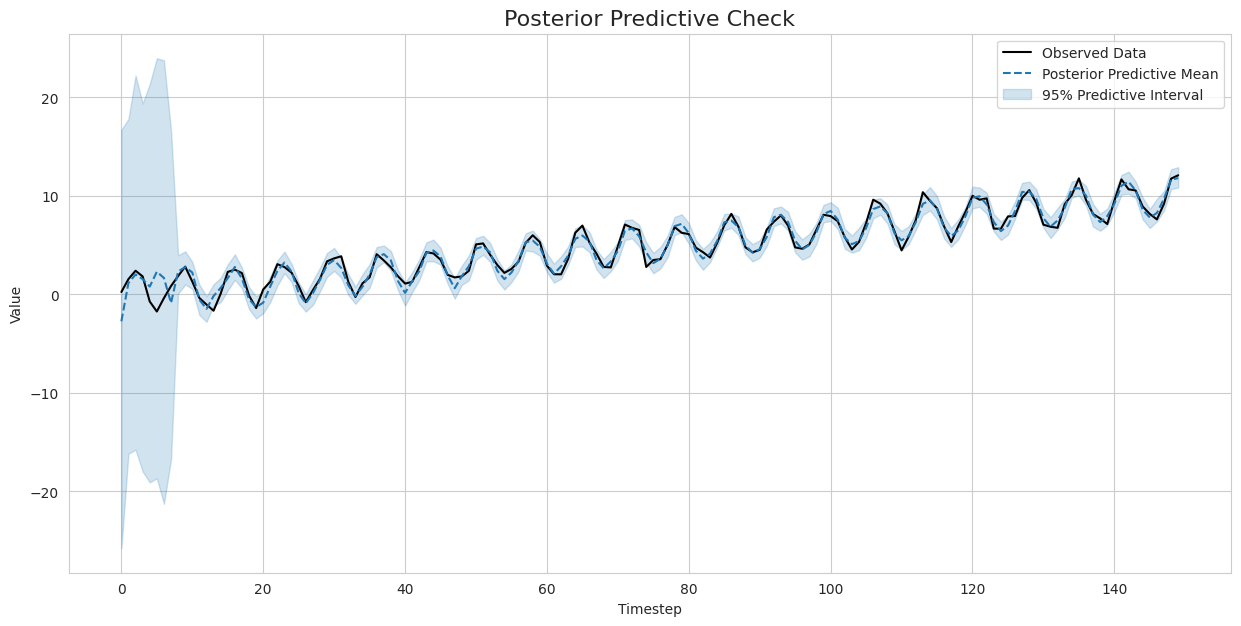

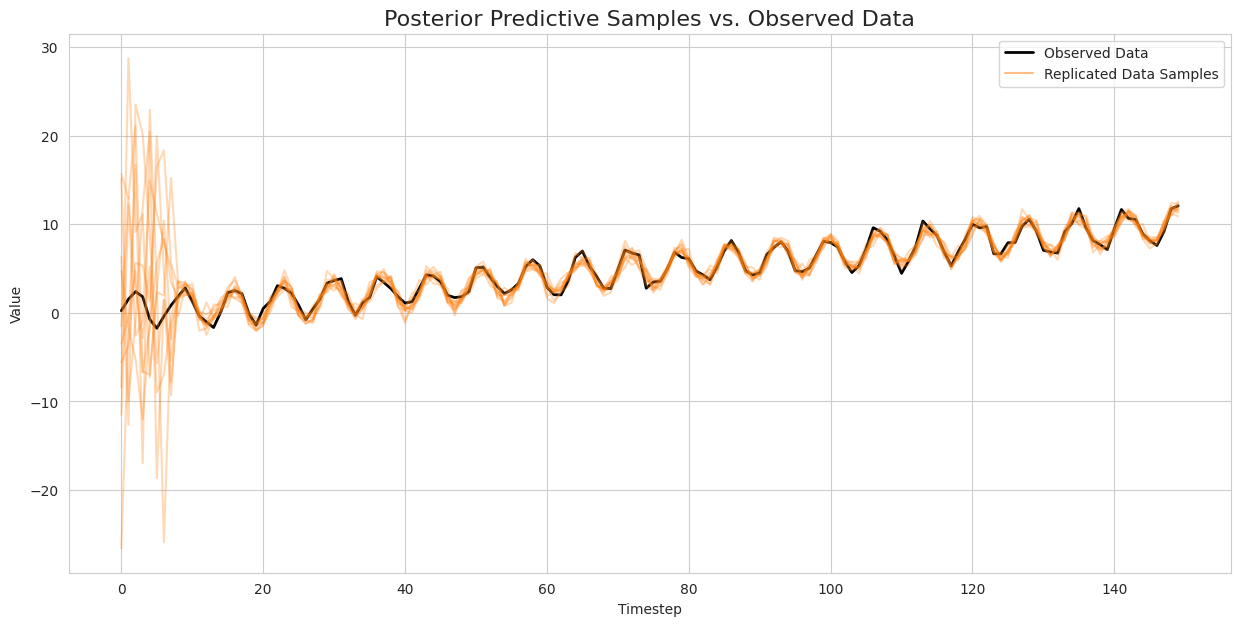

In [36]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn for better plot aesthetics
sns.set_style("whitegrid")

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- 1. Generate Synthetic Time Series Data ---
# Let's create a time series with a linear trend and weekly seasonality.
num_timesteps = 150
observed_series = (
    tf.linspace(0., 10., num_timesteps) +  # Linear trend
    np.sin(2 * np.pi * np.arange(num_timesteps) / 7.) * 2.  # Weekly seasonality
    + np.random.normal(scale=0.5, size=num_timesteps)  # Noise
)
observed_series = tf.cast(observed_series, dtype=tf.float32)

# Plot the generated data
plt.figure(figsize=(12, 6))
plt.plot(observed_series, label="Observed Data")
plt.title("Synthetic Time Series Data")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()


# --- 2. Define the Structural Time Series (STS) Model ---
# We'll define a model that matches the data-generating process:
# a linear trend component and a seasonal component.
def build_sts_model(data):
    """Builds an STS model.

    Args:
      data: A `tf.Tensor` representing the observed time series.

    Returns:
      An instance of `tfp.sts.Sum`.
    """
    # Component for the underlying trend
    trend = tfp.sts.LocalLinearTrend(observed_time_series=data, name='trend')

    # Component for weekly seasonality
    seasonal = tfp.sts.Seasonal(
        num_seasons=7, observed_time_series=data, name='seasonal')

    # The final model is the sum of the components
    model = tfp.sts.Sum(components=[trend, seasonal],
                        observed_time_series=data)
    return model

sts_model = build_sts_model(observed_series)


# --- 3. Fit the Model using Hamiltonian Monte Carlo (HMC) ---
# We use HMC to sample from the posterior distribution of the model's parameters.
# This gives us a set of plausible parameter values given the data.

print("Fitting STS model with HMC...")
# The `fit_with_hmc` function is a convenient wrapper for this process.
# num_results should be large enough for stable estimates.
# num_warmup_steps are steps to discard while the sampler converges.
parameter_samples, kernel_results = tfp.sts.fit_with_hmc(
    model=sts_model,
    observed_time_series=observed_series,
    num_results=200,
    num_warmup_steps=50,
    seed=42)

print("HMC fitting complete.")
print(f"Shape of parameter samples: {parameter_samples[0].shape}")


# --- 4. Perform the Posterior Predictive Check (PPC) ---
# The core idea of PPC is to generate new data from the model using the
# parameters from the posterior distribution. If the model is a good fit,
# the generated data should look similar to the observed data.

# In TFP v0.25.0, you use `tfp.sts.one_step_predictive` to get the
# predictive distribution over the observed data points.
print("Generating posterior predictive samples...")
predictive_dist = tfp.sts.one_step_predictive(
    model=sts_model,
    observed_time_series=observed_series,
    parameter_samples=parameter_samples)

# Now, we sample from this predictive distribution to get our "replicated" data.
# We'll generate a number of replicated datasets equal to the number of HMC samples.
num_samples = 100
posterior_predictive_samples = predictive_dist.sample(num_samples, seed=42)

# The shape will be [num_samples, num_timesteps]
print(f"Shape of posterior predictive samples: {posterior_predictive_samples.shape}")


# --- 5. Visualize the Results ---
# A good way to perform a PPC is to plot the observed data along with
# the credible interval of the posterior predictive samples.

# Calculate the mean and credible interval (e.g., 95%) of the predictions
predicted_mean = tf.reduce_mean(posterior_predictive_samples, axis=0)
predicted_lower = tfp.stats.percentile(posterior_predictive_samples, 2.5, axis=0)
predicted_upper = tfp.stats.percentile(posterior_predictive_samples, 97.5, axis=0)

plt.figure(figsize=(15, 7))
plt.plot(observed_series, 'k', label='Observed Data')
plt.plot(predicted_mean, color='C0', linestyle='--', label='Posterior Predictive Mean')
plt.fill_between(
    range(num_timesteps),
    predicted_lower,
    predicted_upper,
    color='C0',
    alpha=0.2,
    label='95% Predictive Interval'
)

plt.title("Posterior Predictive Check", fontsize=16)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# Another common PPC visualization is to plot a few of the replicated
# datasets directly on top of the observed data.
plt.figure(figsize=(15, 7))
plt.plot(observed_series, 'k', linewidth=2, label='Observed Data')

# Plot a few sample trajectories
for i in range(min(10, num_samples)): # Plot up to 10 samples
    plt.plot(posterior_predictive_samples[i, :], color='C1', alpha=0.3)

# Add a label for the replicated data (only once)
plt.plot([], [], color='C1', alpha=0.5, label='Replicated Data Samples')

plt.title("Posterior Predictive Samples vs. Observed Data", fontsize=16)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()


**Cross-Validation Alternativo**